## Location Sales Estimate Problem


## Background

- **Expansion to Egypt:** Company X is expanding into Egypt.
- **Recommended Locations:** 2670 potential locations identified.
  - **Location A:** 2536 locations, $25,000 operational costs, with sales data.
  - **Location B:** 134 locations, $15,000 operational costs, without sales data.

![title](Assets/Egypt-Map-L.jpg)


### Challenge

- **Feasibility:** Opening all recommended locations is not feasible.
- **Objective:** Select optimal locations for best coverage and sales.

### Assumption

- **Sales Coverage:** A branch covers sales of any other branch within 5 km.
  - **Example:**
    - **Location L1:** $10,000 sales.
    - **Location L2:** $5,000 sales, 2 km away.
    - Selecting one results in combined sales of $15,000.
  - Type A to Type B coverage works similarly.

### Goal

- **Select Minimum Branches:** Ensure maximum coverage and sales.
- **Avoid Losses:** Estimated sales must exceed operational costs.

## Data Overview

***We received data on 2670 recommended locations, categorized into two types:***

    Type A: 2536 locations with an operational cost of 25,000 and available estimated sales data.
    Type B: 134 locations with an operational cost of 15,000, without specific sales data but can cover nearby Type A locations within a 5 km radius."

#### Modules

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,OPTICS
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.neighbors import BallTree
import hdbscan
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [168]:
dataFrameTypeA=pd.read_excel("E:\Fawry_ML_Task\Data\Fawry - Data Science - AI Task.xlsx",sheet_name='Type A')
dataFrameTypeB=pd.read_excel("E:\Fawry_ML_Task\Data\Fawry - Data Science - AI Task.xlsx",sheet_name='Type B')

In [169]:
dataFrameTypeA.head()

ID         Gov City_Type   Latitude  Longitude  Estimated_Sales
0   1     الشرقية       حضر  30.727543  31.793701     72021.026667
1   2     القاهرة       حضر  30.235685  31.467567     54690.637778
2   3    المنوفية       حضر  30.361963  30.512031     42379.708889
3   4       أسوان       حضر  24.977806  32.875934     42377.312222
4   5  مرسى مطروح       حضر  31.355745  27.244068     40826.774444

In [170]:
dataFrameTypeB.head()

ID     Gov   Latitude  Longitude
0   1  الجيزة  29.948291  31.051539
1   2  الجيزة  30.048963  30.974668
2   3  الجيزة  30.061117  30.960385
3   4  الفيوم  29.361996  30.683888
4   5  الفيوم  29.413400  30.862680

### Data Cleaning and Preprocessing

### Check Nulls

In [171]:
print(dataFrameTypeA.isna().sum())
print(dataFrameTypeB.isna().sum())

ID                 0
Gov                0
City_Type          0
Latitude           0
Longitude          0
Estimated_Sales    0
dtype: int64
ID           0
Gov          0
Latitude     0
Longitude    0
dtype: int64


### Check Duplicates

In [172]:
print(dataFrameTypeA.duplicated().sum())
print(dataFrameTypeB.duplicated().sum())

0
0


### Assing cost and type

In [173]:
dataFrameTypeA["Type"]='A'
dataFrameTypeB["Type"]='B'
dataFrameTypeA["operational_costs"]=25000
dataFrameTypeB["operational_costs"]=15000

In [174]:
dataFrameTypeA.head()

ID         Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0   1     الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1   2     القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2   3    المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3   4       أسوان       حضر  24.977806  32.875934     42377.312222    A   
4   5  مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   

   operational_costs  
0              25000  
1              25000  
2              25000  
3              25000  
4              25000

In [175]:
dataFrameTypeB.head()

ID     Gov   Latitude  Longitude Type  operational_costs
0   1  الجيزة  29.948291  31.051539    B              15000
1   2  الجيزة  30.048963  30.974668    B              15000
2   3  الجيزة  30.061117  30.960385    B              15000
3   4  الفيوم  29.361996  30.683888    B              15000
4   5  الفيوم  29.413400  30.862680    B              15000

### Number of Governments in data

In [176]:
len(dataFrameTypeA["Gov"].unique())

27

In [177]:
len(dataFrameTypeB["Gov"].unique())

15

In [178]:
len(pd.concat([dataFrameTypeA, dataFrameTypeB], ignore_index=True)["Gov"].unique())

29

In [179]:
import arabic_reshaper
from bidi.algorithm import get_display

# Calculate the value counts
gov_counts = pd.concat([dataFrameTypeA, dataFrameTypeB], ignore_index=True)['Gov'].value_counts()

# Reshape and reverse Arabic text for correct display
reshaped_text = [get_display(arabic_reshaper.reshape(text)) for text in gov_counts.index]

### Governments Location Counts

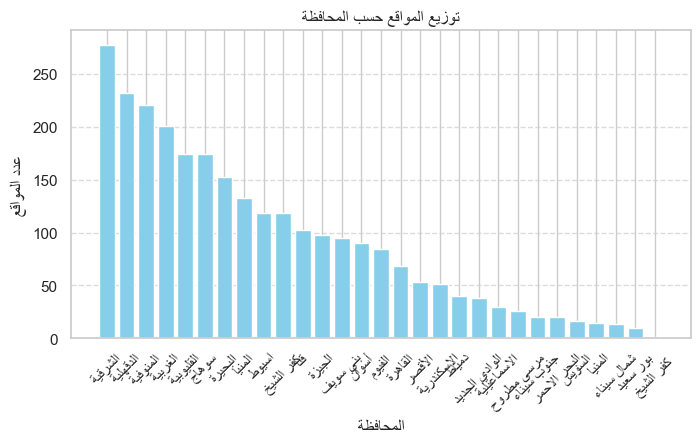

In [180]:
plt.figure(figsize=(8, 4))
plt.bar(reshaped_text, gov_counts, color='skyblue')
plt.title(get_display(arabic_reshaper.reshape('توزيع المواقع حسب المحافظة')))
plt.xlabel(get_display(arabic_reshaper.reshape('المحافظة')))
plt.ylabel(get_display(arabic_reshaper.reshape('عدد المواقع')))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

## Helper Methods

In [181]:
# Function to calculate distance matrix using Haversine formula
def haversine_matrix(latlon1, latlon2, lat2=None, lon2=None, bcase=True,single=False):
    R = 6371  # Radius of Earth in kilometers
    if bcase:
        lat1, lon1 = latlon1[:, 0], latlon1[:, 1]
        lat2, lon2 = latlon2[:, 0], latlon2[:, 1]
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1[:, None]
        dlat = lat2 - lat1[:, None]
    else:
        lat1, lon1, lat2, lon2 = map(np.radians, [latlon1, latlon2, lat2, lon2])
        if single==True:
            delta_lat = lat2 - lat1
            delta_lon = lon2 - lon1
            a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
            c = 2 * np.arcsin(np.sqrt(a))
            return R * c
        dlat = lat2 - lat1[:, np.newaxis]
        dlon = lon2 - lon1[:, np.newaxis]
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1[:, np.newaxis]) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [182]:
# Filter rows based on distance
def filterRowsWithinDistance(df, distance_km=5):
    filtered_indices = []
    for idx, row in df.iterrows():
        current_lat, current_lon = row['Latitude'], row['Longitude']
        within_distance = False
        for i in filtered_indices:
            lat, lon = df.loc[i, 'Latitude'], df.loc[i, 'Longitude']
            if haversine_matrix(current_lat, current_lon, lat, lon,bcase=False,single=True) <= distance_km:
                within_distance = True
                break
        if not within_distance:
            filtered_indices.append(idx)
    return filtered_indices

In [183]:
def plotDataFrameLongLatWithType(df,clstr=False,showdistance=False,showNumber=False):
    sns.set(style="whitegrid")

    # Create a figure and axis
    plt.figure(figsize=(12, 8))

    # Create a scatter plot with different colors for each type
    if clstr==True:
        sns.scatterplot(
        data=df,
        x='Longitude', y='Latitude',
        style="Type",hue='cluster',
        palette='Set3', s=100, alpha=0.7,legend='full'
        )
    else:
        sns.scatterplot(
        data=df,
        x='Longitude', y='Latitude',
        hue="Type",
        palette='Set3', s=100, alpha=0.7,legend='full'
        )

    # Set plot title and labels
    plt.title('Scatter Plot of Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    if showdistance:
        # Calculate and annotate distances
        coords = df[['Latitude', 'Longitude']].to_numpy()
        for (i, j) in combinations(range(len(coords)), 2):
            dist = haversine_matrix(coords[i].reshape(1, -1), coords[j].reshape(1, -1))
            dist = dist.item()  # Extract scalar value from NumPy arra
            if dist <= 5:
                lat1, lon1 = coords[i]
                lat2, lon2 = coords[j]
                plt.plot([lon1, lon2], [lat1, lat2], 'k-', alpha=0.3)
                mid_lat = (lat1 + lat2) / 2
                mid_lon = (lon1 + lon2) / 2
                plt.text(mid_lon, mid_lat, f'{dist:.2f} km', fontsize=9, ha='center', va='center')
    if showNumber:                
        for line in range(0, df.shape[0]):
            plt.text(df.Longitude[line], df.Latitude[line],
                    df.cluster[line], horizontalalignment='left', 
                    size=6, color='black', weight='semibold')
    
    # Show legend
    # plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [184]:
def ballTreeCall(treeDf,searchDf):
    ball = BallTree(np.radians(treeDf[["Latitude","Longitude"]]), metric='haversine')
    indices ,distances= ball.query_radius(np.radians(searchDf[["Latitude","Longitude"]]), return_distance=True,r=5/6371.0,sort_results=True)
    distances=distances*6371 ## to km
    return indices,distances

In [185]:
def filterCluster(cluster_df):
    # Sort points by Coverage in descending order
    sorted_points = cluster_df.sort_values(by='Coverage', ascending=False)
    for _, max_coverage_point in sorted_points.iterrows():
        # Calculate the Haversine distance from the max_coverage_point to all other points in the cluster
        distances = cluster_df.apply(lambda row: haversine_matrix(max_coverage_point['Latitude'], 
                                                           max_coverage_point['Longitude'], 
                                                           row['Latitude'], 
                                                           row['Longitude'],bcase=False,single=True), axis=1)
        
        # Check if all distances are within 5 km
        if all(distances <= 5):
            return max_coverage_point
    
    # If no point satisfies the condition, return MAX_COVER
    return sorted_points.iloc[0]


In [186]:
def selectPoints(df):
    selected_points = df.groupby('cluster').apply(filterCluster).reset_index(drop=True)
    return selected_points

In [187]:
def displayRemovedLocations(df):
    lossMakingBranches = df[df["updatedEstimastedSales"] < df["operational_costs"]]
    profitMakingBranches = df[df["updatedEstimastedSales"] > df["operational_costs"]]

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot loss-making branches in red
    plt.scatter(lossMakingBranches['Longitude'], lossMakingBranches['Latitude'], 
                color='red', label='Loss Making Branches', alpha=0.6)

    # Plot profit-making branches in green
    plt.scatter(profitMakingBranches['Longitude'], profitMakingBranches['Latitude'], 
                color='green', label='Profit Making Branches', alpha=0.6)

    # Add title and labels
    plt.title('Geographical Distribution of Branches Based on Profitability')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

### Display Locations

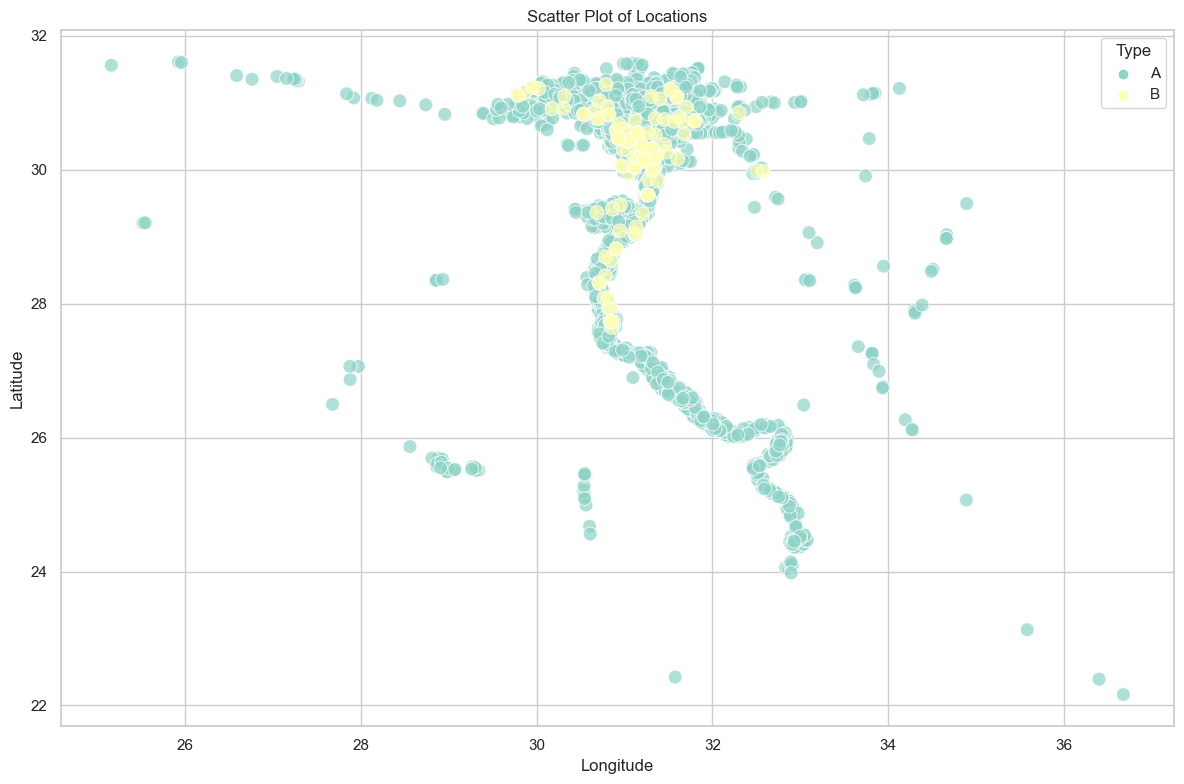

In [188]:
plotDataFrameLongLatWithType(pd.concat([dataFrameTypeA, dataFrameTypeB], ignore_index=True))

### Haversine Distance
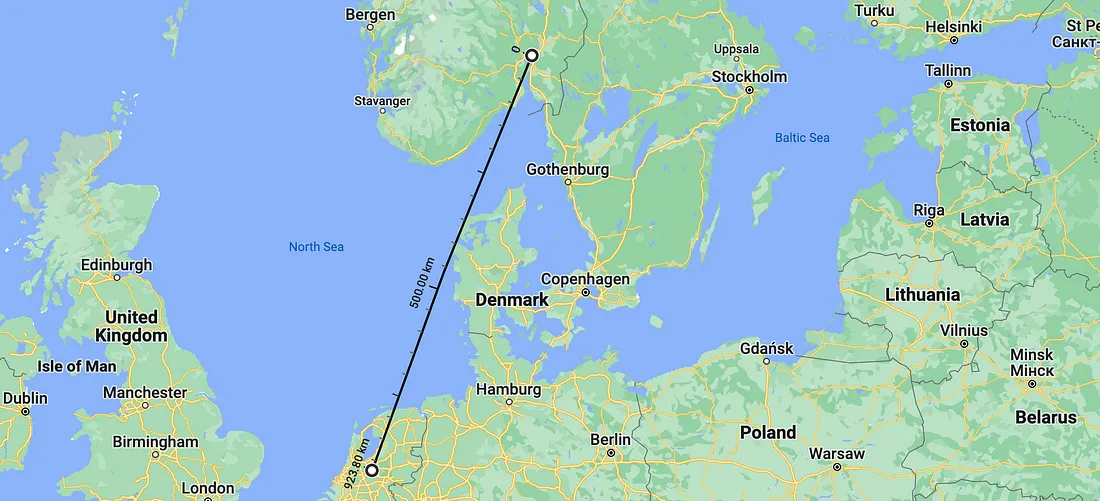

***Latitude***: This measures how far north or south a location is from the Equator, which is 0 degrees latitude. Latitude values range from 0 degrees at the Equator to 90 degrees north at the North Pole and 90 degrees south at the South Pole.

***Longitude***: This measures how far east or west a location is from the Prime Meridian, which is 0 degrees longitude,Longitude values range from 0 degrees at the Prime Meridian to 180 degrees east and 180 degrees west.  

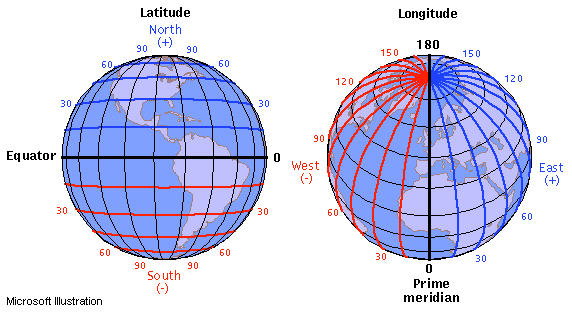

### why we use haversine distance

The Haversine formula is used to calculate the shortest distance between two points on the surface of a sphere, which in this case is the Earth. The distance calculated using the Haversine formula is called the great-circle distance.

***Accuracy Over Long Distances***: The Haversine formula accounts for the spherical shape of the Earth, making it accurate for long distances, unlike simple Euclidean distance which assumes a flat surface.

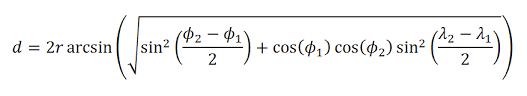

## Methodolgy

***Option 1: Apply Clustering After Computing Estimated Sales***

1-**Compute Individual Sales Estimates:**\
For each Type A location, sum the estimated sales of all other Type A locations within 5 km.
For Type B locations, assign the highest nearby Type A sales estimate within 5 km.

2-**Filter Locations Based on Sales vs. Costs:**\
Identify which locations (both Type A and Type B) have sales estimates that meet or exceed their respective operational costs.

3-**Cluster Filtered Locations:**\
Apply a clustering algorithm to the filtered list of locations (those that have sales estimates covering operational costs) to group them based on their geographic coordinates with a 5 km distance parameter.

***Option 2: Apply Clustering Before Computing Estimated Sales***

1-**Cluster Locations:**\
    Use a clustering algorithm (DBSCAN, OPTICS, HDBSCAN) to group locations based on their geographic coordinates (latitude and longitude) with a distance parameter set to 5 km.
    This will help identify clusters of locations that are within 5 km of each other.

2-**Compute Combined Sales for Each Cluster:**\
    For each cluster, sum the estimated sales of all locations within that cluster.
    Assign the combined sales to a representative location (e.g., the centroid of the cluster or the location with the highest sales within the cluster).

3-**Evaluate Clusters Against Operational Costs:**\
    Determine if the combined sales for each cluster meet or exceed the operational costs.
    Select the clusters (or representative locations) that achieve the best coverage and sales.

### Option 1

##### ***Brute Algorthim***

Copy Version For Brute Algorthim

In [189]:
dataFrameTypeABrute=dataFrameTypeA
dataFrameTypeBBrute=dataFrameTypeB

**Recommendation-A** Calculation

In [190]:
# Compute the distance matrix
distance_matrix = haversine_matrix(dataFrameTypeABrute['Latitude'].values, dataFrameTypeABrute['Longitude'].values, dataFrameTypeABrute['Latitude'].values, dataFrameTypeABrute['Longitude'].values,bcase=False)
# Boolean matrix for distances within the specified radius (5 km)
within_radius = distance_matrix <= 5
# Sum the sales for points within 5 km for each point
estimated_sales = dataFrameTypeABrute['Estimated_Sales'].values
summed_sales = within_radius.dot(estimated_sales)
# Add the new estimated sales to the DataFrame
dataFrameTypeABrute['updatedEstimastedSales'] = summed_sales

**Recommendation-B** Calculation

In [191]:
# Calculate distance matrix between data_a and data_b
distances = haversine_matrix(dataFrameTypeBBrute[['Latitude', 'Longitude']].to_numpy(), dataFrameTypeABrute[['Latitude', 'Longitude']].to_numpy())
# Find index of nearest point in data_a for each point in data_b
nearest_indices = distances.argmin(axis=1)
# Assign the estimated_sales of the nearest points to data_b
dataFrameTypeBBrute['updatedEstimastedSales'] = dataFrameTypeABrute.iloc[nearest_indices]['updatedEstimastedSales'].values

Combine All Location Togheter To select from them

In [192]:
combinedDfBrute = pd.concat([dataFrameTypeABrute, dataFrameTypeBBrute], ignore_index=True)

***Apply Fiter for not take Locations that EstimatedSales<Operation cost***

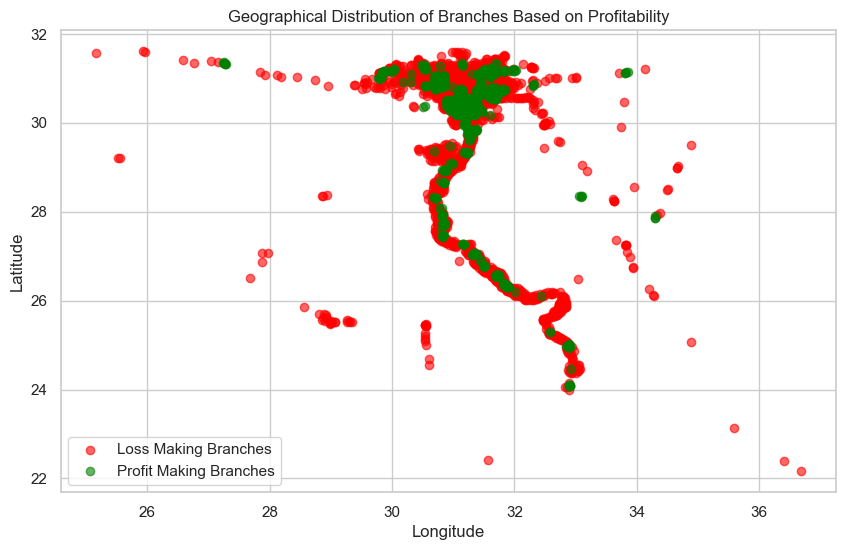

In [193]:
displayRemovedLocations(combinedDfBrute)

In [194]:
combinedDfBrute=combinedDfBrute[combinedDfBrute["updatedEstimastedSales"]>combinedDfBrute["operational_costs"]]

Create Column For Coverage

In [195]:
combinedDfBrute["Coverage"]=combinedDfBrute["updatedEstimastedSales"]-combinedDfBrute["operational_costs"]

Sort to get the maximum coverage

In [196]:
combinedDfBrute = combinedDfBrute.sort_values('Coverage', ascending=False).reset_index(drop=True)

In [197]:
combinedDfBrute

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1    1350  القليوبية       ريف  30.307533  31.281235       448.888889    A   
2      55  القليوبية       حضر  30.318952  31.313721     18110.285556    A   
3     735  القليوبية       ريف  30.337151  31.315433      1474.474444    A   
4      59    الشرقية       NaN  30.723517  31.793006              NaN    B   
..    ...        ...       ...        ...        ...              ...  ...   
642  1757   بني سويف       ريف  29.062851  30.990756       227.231111    A   
643  2506   المنوفية       ريف  30.522489  31.048552        38.137778    A   
644  1918      سوهاج       ريف  26.313095  31.884431       177.594444    A   
645  2179      سوهاج       ريف  26.313097  31.884433       103.340000    A   
646  1790   المنوفية       ريف  30.486923  31.091857       213.520000    A   

     operational_costs  updatedEstimastedSales      Coverage  
0                15000           109193.996167  94193.996167  
1                25000           118395.498389  93395.498389  
2                25000           109193.996167  84193.996167  
3                25000           109049.395056  84049.395056  
4                15000            96210.856667  81210.856667  
..                 ...                     ...           ...  
642              25000            25172.226667    172.226667  
643              25000            25133.851111    133.851111  
644              25000            25089.566667     89.566667  
645              25000            25089.566667     89.566667  
646              25000            25011.921111     11.921111  

[647 rows x 10 columns]

##### ***Ball Tree***

**Ball Tree Construction Steps:**

1. **Select a Random Point**.
2. **Find the Farthest Point (Point A)**.
3. **Find the Farthest Point from Point A (Point B)**.
4. **Draw a Line Between Point A and Point B**.
5. **Calculate Distances to the Line**.
6. **Find the Median Point**.
7. **Split the Data into Two Balls**.
8. **Repeat Recursively**.


![title](Assets/ball_tree_steps/step_1.png)

![title](Assets/ball_tree_steps/step_2.png)

![title](Assets/ball_tree_steps/step_3.png)

![title](Assets/ball_tree_steps/step_4.png)

![title](Assets/ball_tree_steps/step_5.png)

![title](Assets/Ball-tree%20Example.png)

Copy Version For Ball Tree Algorthim

In [198]:
dataFrameTypeABall=dataFrameTypeA
dataFrameTypeBBall=dataFrameTypeB

**Recommendation-A** Calculation

In [199]:
indices,distances=ballTreeCall(dataFrameTypeABall,dataFrameTypeABall)
updatedEstimastedSales=[round(sum([dataFrameTypeABall.iloc[idx]["Estimated_Sales"] for idx in indices[i]]),3) for i in range(len(dataFrameTypeABall))]
dataFrameTypeABall["updatedEstimastedSales"]=updatedEstimastedSales

**Recommendation-B** Calculation

In [200]:
indices,distances=ballTreeCall(dataFrameTypeABall,dataFrameTypeBBall)
estimated_sales=[]
for i in range(len(dataFrameTypeBBall)):
    if len(indices[i])>0:
        estimated_sales.append(round(dataFrameTypeABall.iloc[indices[i][0]]["updatedEstimastedSales"],3))
    else:
        estimated_sales.append(0.0)
dataFrameTypeBBall["updatedEstimastedSales"]=estimated_sales

Combine All Location Togheter To select from them

In [201]:
combinedDfBall = pd.concat([dataFrameTypeABall, dataFrameTypeBBall], ignore_index=True)

***Apply Fiter for not take Locations that EstimatedSales<Operation cost***

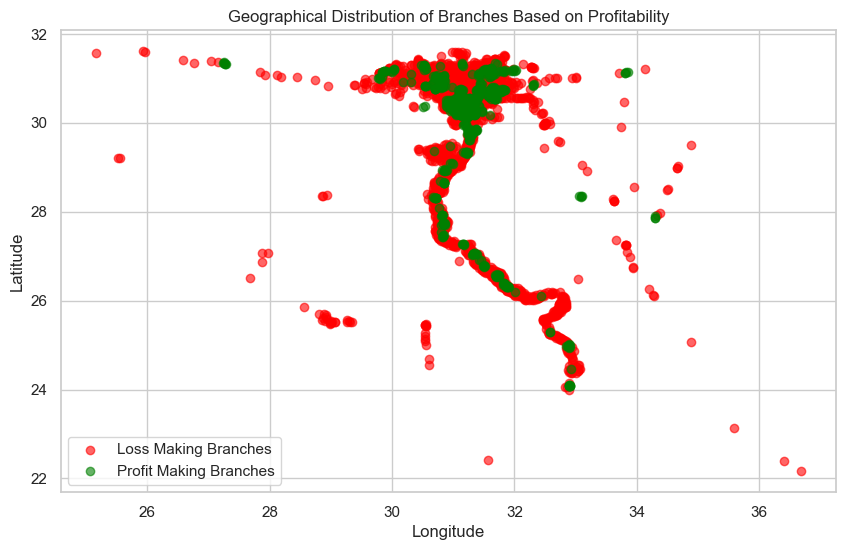

In [202]:
displayRemovedLocations(combinedDfBall)

#### Number of removed locations

In [203]:
len(combinedDfBall[combinedDfBall["updatedEstimastedSales"]<combinedDfBall["operational_costs"]])

2024

Remove Location That their costs greater than their sales

In [204]:
combinedDfBall=combinedDfBall[combinedDfBall["updatedEstimastedSales"]>combinedDfBall["operational_costs"]]

Create Column For Coverage

In [205]:
combinedDfBall["Coverage"]=combinedDfBall["updatedEstimastedSales"]-combinedDfBall["operational_costs"]

Result Data Frame

In [206]:
combinedDfBall

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0       1      الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1       2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2       3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3       4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
4       5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
...   ...          ...       ...        ...        ...              ...  ...   
2663  128    القليوبية       NaN  30.145500  31.215355              NaN    B   
2664  129    القليوبية       NaN  30.318393  31.310492              NaN    B   
2665  130    القليوبية       NaN  30.186000  31.353272              NaN    B   
2666  131    القليوبية       NaN  30.138000  31.220216              NaN    B   
2667  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   

      operational_costs  updatedEstimastedSales   Coverage  
0                 25000               96084.883  71084.883  
1                 25000               57434.150  32434.150  
2                 25000               51029.819  26029.819  
3                 25000               63934.114  38934.114  
4                 25000               68756.226  43756.226  
...                 ...                     ...        ...  
2663              15000               47367.362  32367.362  
2664              15000              109193.996  94193.996  
2665              15000               30255.746  15255.746  
2666              15000               47367.362  32367.362  
2667              15000               28021.987  13021.987  

[646 rows x 10 columns]

In [207]:
combinedDfBrute

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1    1350  القليوبية       ريف  30.307533  31.281235       448.888889    A   
2      55  القليوبية       حضر  30.318952  31.313721     18110.285556    A   
3     735  القليوبية       ريف  30.337151  31.315433      1474.474444    A   
4      59    الشرقية       NaN  30.723517  31.793006              NaN    B   
..    ...        ...       ...        ...        ...              ...  ...   
642  1757   بني سويف       ريف  29.062851  30.990756       227.231111    A   
643  2506   المنوفية       ريف  30.522489  31.048552        38.137778    A   
644  1918      سوهاج       ريف  26.313095  31.884431       177.594444    A   
645  2179      سوهاج       ريف  26.313097  31.884433       103.340000    A   
646  1790   المنوفية       ريف  30.486923  31.091857       213.520000    A   

     operational_costs  updatedEstimastedSales      Coverage  
0                15000           109193.996167  94193.996167  
1                25000           118395.498389  93395.498389  
2                25000           109193.996167  84193.996167  
3                25000           109049.395056  84049.395056  
4                15000            96210.856667  81210.856667  
..                 ...                     ...           ...  
642              25000            25172.226667    172.226667  
643              25000            25133.851111    133.851111  
644              25000            25089.566667     89.566667  
645              25000            25089.566667     89.566667  
646              25000            25011.921111     11.921111  

[647 rows x 10 columns]

Display Plots with the points contains distance 5km between each other

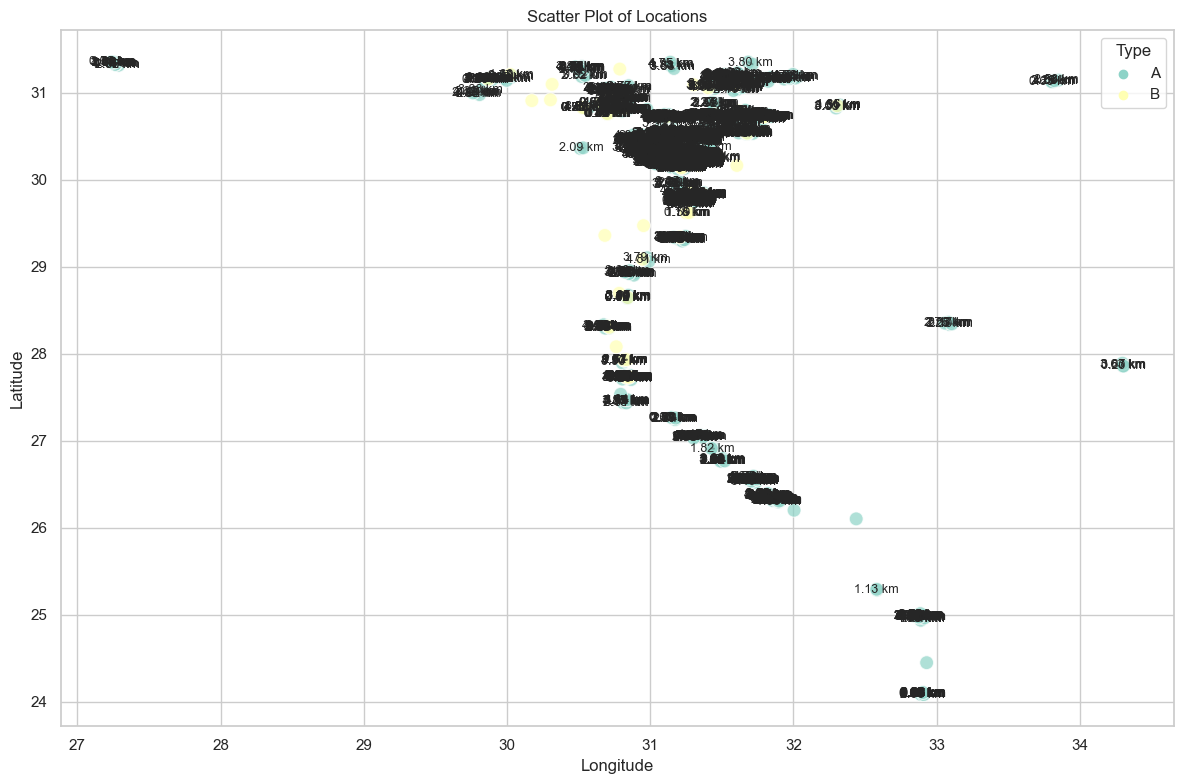

In [208]:
plotDataFrameLongLatWithType(combinedDfBall,showdistance=True)

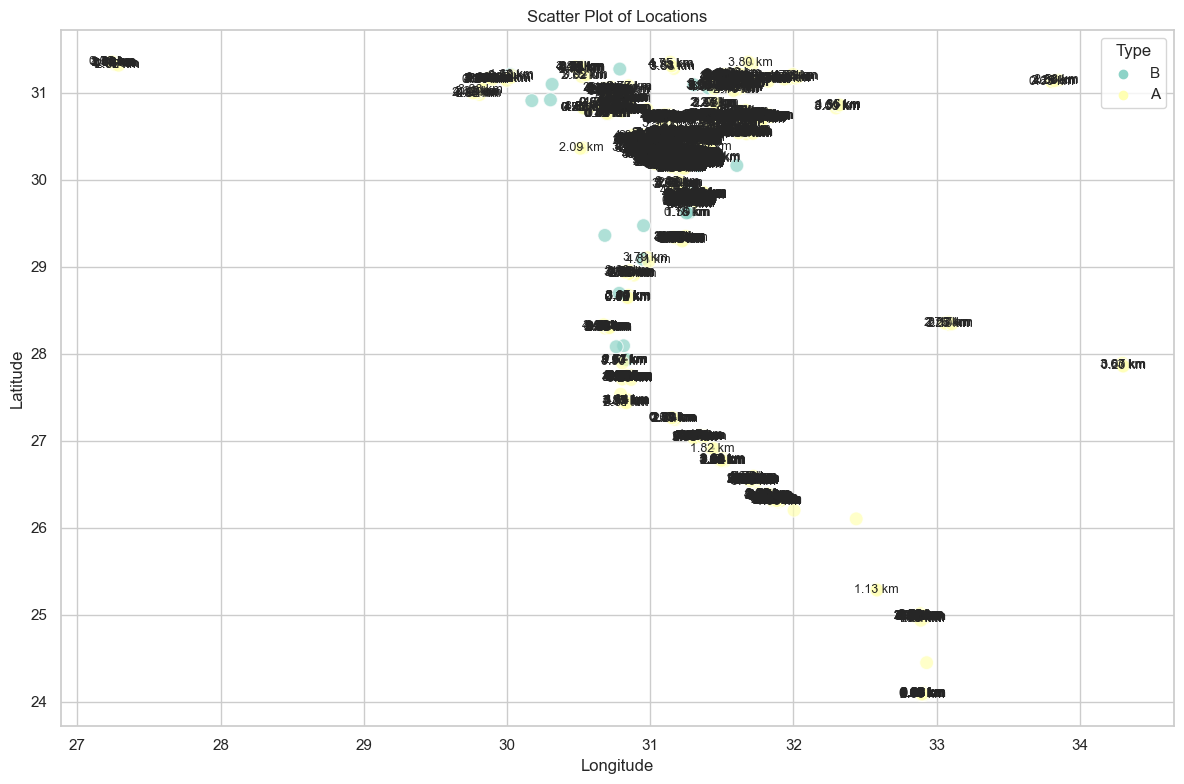

In [209]:
plotDataFrameLongLatWithType(combinedDfBrute,showdistance=True)

#### ***Conclusion***
We need to apply clustring algorthim or apply anyy algorthim that takes the hieghst coverage withing 5km range

#### ***Filter Algorthim***

Select the points that have heighst coverage and be sure that no point within it in 5km range so we can filter based on coverage and range

![title](Assets/ball_tree_steps/imarg.png)


In [210]:
selectedPoints = combinedDfBrute.sort_values('Coverage', ascending=False).reset_index(drop=True)
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfBrute = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfBrute

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1      59    الشرقية       NaN  30.723517  31.793006              NaN    B   
2     116  القليوبية       ريف  30.155107  31.192262     12431.234444    A   
3    1946  القليوبية       ريف  30.284461  31.347094       168.683333    A   
4     343  القليوبية       ريف  30.217819  31.209151      4702.623333    A   
..    ...        ...       ...        ...        ...              ...  ...   
132   643    الشرقية       ريف  30.534998  31.717706      1864.231111    A   
133   695        قنا       ريف  26.103429  32.439087      1614.741111    A   
134  1593  كفر الشيخ       ريف  31.280505  31.165862       305.967778    A   
135   452   المنوفية       ريف  30.516160  30.883343      3224.993333    A   
136  1982      اسيوط       ريف  27.535805  30.793993       158.595556    A   

     operational_costs  updatedEstimastedSales      Coverage  
0                15000           109193.996167  94193.996167  
1                15000            96210.856667  81210.856667  
2                25000           105264.344444  80264.344444  
3                25000            94386.237344  69386.237344  
4                25000            85800.951111  60800.951111  
..                 ...                     ...           ...  
132              25000            25760.224444    760.224444  
133              25000            25749.605556    749.605556  
134              25000            25678.984444    678.984444  
135              25000            25649.080000    649.080000  
136              25000            25604.987778    604.987778  

[137 rows x 10 columns]

BriefSummary

In [211]:
print(f"The Total Number of Location Selected:{len(resultDfBrute)}")
print(f"The Total Number of A-Location Selected:{len(resultDfBrute[resultDfBrute['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfBrute[resultDfBrute['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfBrute)}")
print(f"The Total Sales Equals:{resultDfBrute['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfBrute['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfBrute['operational_costs'].sum()}")

The Total Number of Location Selected:137
The Total Number of A-Location Selected:94
The Total Number of B-Location Selected:43
The Total Number of Locations Covered by selected:647
The Total Sales Equals:5601378.195133333
The Total Coverage Equals:2606378.1951333336
The Total Costs Equals:2995000


DisplayResults

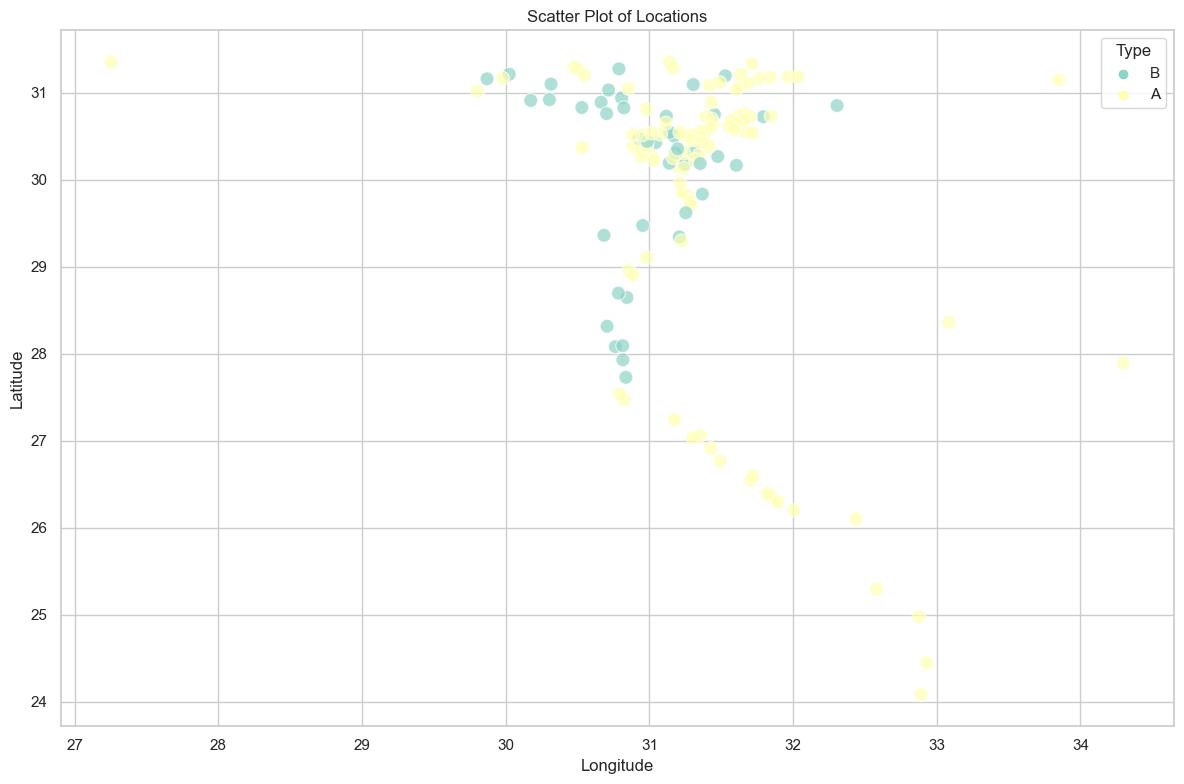

In [212]:
plotDataFrameLongLatWithType(resultDfBrute,showdistance=True)

In [213]:
selectedPoints = combinedDfBall.sort_values('Coverage', ascending=False).reset_index(drop=True)
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfBall = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfBall

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1      59    الشرقية       NaN  30.723517  31.793006              NaN    B   
2     116  القليوبية       ريف  30.155107  31.192262     12431.234444    A   
3    1946  القليوبية       ريف  30.284461  31.347094       168.683333    A   
4     343  القليوبية       ريف  30.217819  31.209151      4702.623333    A   
..    ...        ...       ...        ...        ...              ...  ...   
131   643    الشرقية       ريف  30.534998  31.717706      1864.231111    A   
132   695        قنا       ريف  26.103429  32.439087      1614.741111    A   
133  1593  كفر الشيخ       ريف  31.280505  31.165862       305.967778    A   
134   452   المنوفية       ريف  30.516160  30.883343      3224.993333    A   
135  1982      اسيوط       ريف  27.535805  30.793993       158.595556    A   

     operational_costs  updatedEstimastedSales   Coverage  
0                15000              109193.996  94193.996  
1                15000               96210.857  81210.857  
2                25000              105264.344  80264.344  
3                25000               94386.237  69386.237  
4                25000               85800.951  60800.951  
..                 ...                     ...        ...  
131              25000               25760.224    760.224  
132              25000               25749.606    749.606  
133              25000               25678.984    678.984  
134              25000               25649.080    649.080  
135              25000               25604.988    604.988  

[136 rows x 10 columns]

BriefSummary

In [214]:
print(f"The Total Number of Location Selected:{len(resultDfBall)}")
print(f"The Total Number of A-Location Selected:{len(resultDfBall[resultDfBall['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfBall[resultDfBall['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfBall)}")
print(f"The Total Sales Equals:{resultDfBall['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfBall['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfBall['operational_costs'].sum()}")

The Total Number of Location Selected:136
The Total Number of A-Location Selected:94
The Total Number of B-Location Selected:42
The Total Number of Locations Covered by selected:646
The Total Sales Equals:5579939.26
The Total Coverage Equals:2599939.2600000002
The Total Costs Equals:2980000


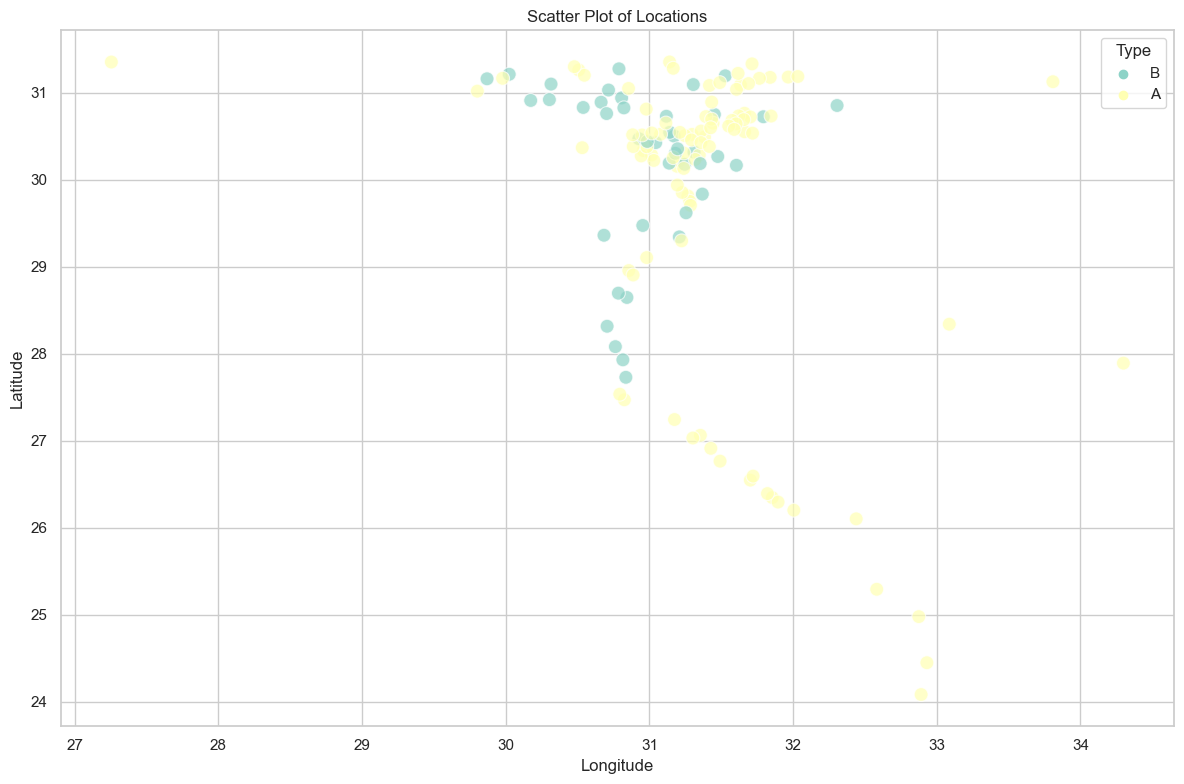

In [215]:
plotDataFrameLongLatWithType(resultDfBall,showdistance=True)

##### Additional Step for Coverage Optimization(Cluster Algorthims)

#### Clustring Algorthims

***DBSCAN***

DBSCAN is a different type of clustering algorithm with some unique advantages. As the name indicates, this method focuses more on the proximity and density of observations to form clusters

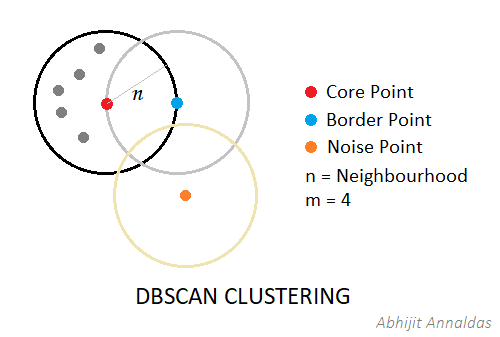

In [216]:
combinedDfBallDBSCN=combinedDfBall

Apply Clustring After perform Standrliztion and Convert to radians

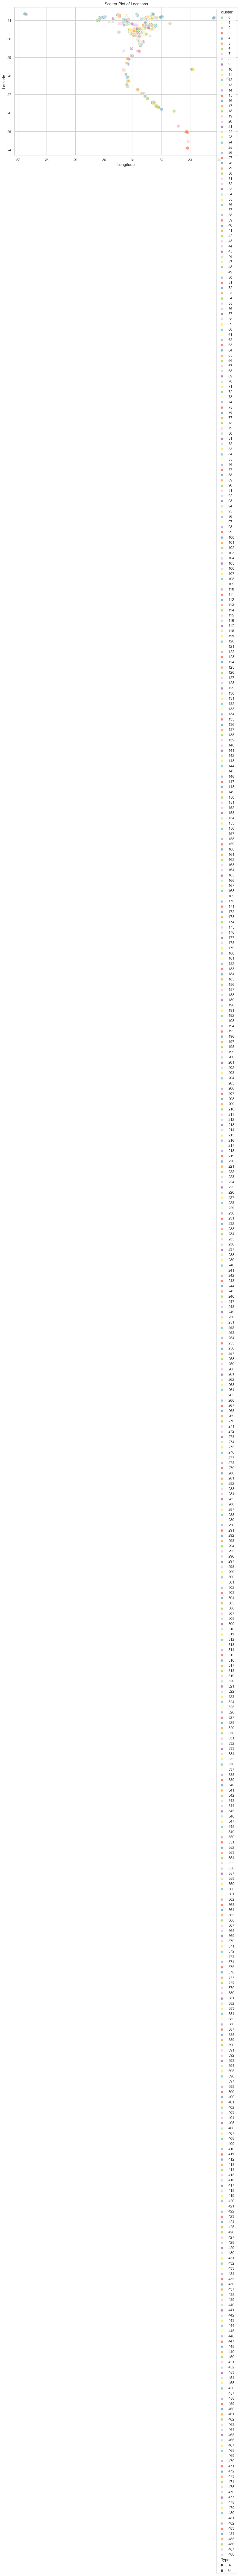

In [217]:
srd=MinMaxScaler()
db = DBSCAN(eps=6/6371.0, min_samples=1, metric='haversine',algorithm='brute')  
y_db = db.fit_predict(srd.fit_transform(np.radians(combinedDfBallDBSCN[["Longitude","Latitude"]])))
combinedDfBallDBSCN['cluster'] = y_db
plotDataFrameLongLatWithType(combinedDfBallDBSCN,clstr=True)

***Select the Point from each cluster based on Distance wihtin same cluster and it's higher coverage amount***\
For each cluster we take the point that have hiegher coverage amount and wihtin 5km to all points in the cluster


In [218]:
selectedClustePoints = selectPoints(combinedDfBallDBSCN)

Select the point that heighst coverage within 5km range Apply **Filter**

In [219]:
selectedPoints = selectedClustePoints.sort_values('Coverage', ascending=False).reset_index(drop=True)
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfBallClusterDBSCN = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfBallClusterDBSCN

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1      58    الشرقية       NaN  30.732944  31.808439              NaN    B   
2     116  القليوبية       ريف  30.155107  31.192262     12431.234444    A   
3    1946  القليوبية       ريف  30.284461  31.347094       168.683333    A   
4     765    الشرقية       ريف  30.717965  31.756487      1339.983333    A   
..    ...        ...       ...        ...        ...              ...  ...   
133   643    الشرقية       ريف  30.534998  31.717706      1864.231111    A   
134   695        قنا       ريف  26.103429  32.439087      1614.741111    A   
135  1593  كفر الشيخ       ريف  31.280505  31.165862       305.967778    A   
136   452   المنوفية       ريف  30.516160  30.883343      3224.993333    A   
137  1982      اسيوط       ريف  27.535805  30.793993       158.595556    A   

     operational_costs  updatedEstimastedSales   Coverage  cluster  
0                15000              109193.996  94193.996       20  
1                15000               96210.857  81210.857      468  
2                25000              105264.344  80264.344       73  
3                25000               94386.237  69386.237      374  
4                25000               91977.783  66977.783      203  
..                 ...                     ...        ...      ...  
133              25000               25760.224    760.224      179  
134              25000               25749.606    749.606      186  
135              25000               25678.984    678.984      316  
136              25000               25649.080    649.080      155  
137              25000               25604.988    604.988      378  

[138 rows x 11 columns]

BriefSummary

In [220]:
print(f"The Total Number of Location Selected:{len(resultDfBallClusterDBSCN)}")
print(f"The Total Number of A-Location Selected:{len(resultDfBallClusterDBSCN[resultDfBallClusterDBSCN['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfBallClusterDBSCN[resultDfBallClusterDBSCN['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfBallDBSCN)}")
print(f"The Total Sales Equals:{resultDfBallClusterDBSCN['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfBallClusterDBSCN['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfBallClusterDBSCN['operational_costs'].sum()}")

The Total Number of Location Selected:138
The Total Number of A-Location Selected:96
The Total Number of B-Location Selected:42
The Total Number of Locations Covered by selected:646
The Total Sales Equals:5701418.605
The Total Coverage Equals:2671418.605
The Total Costs Equals:3030000


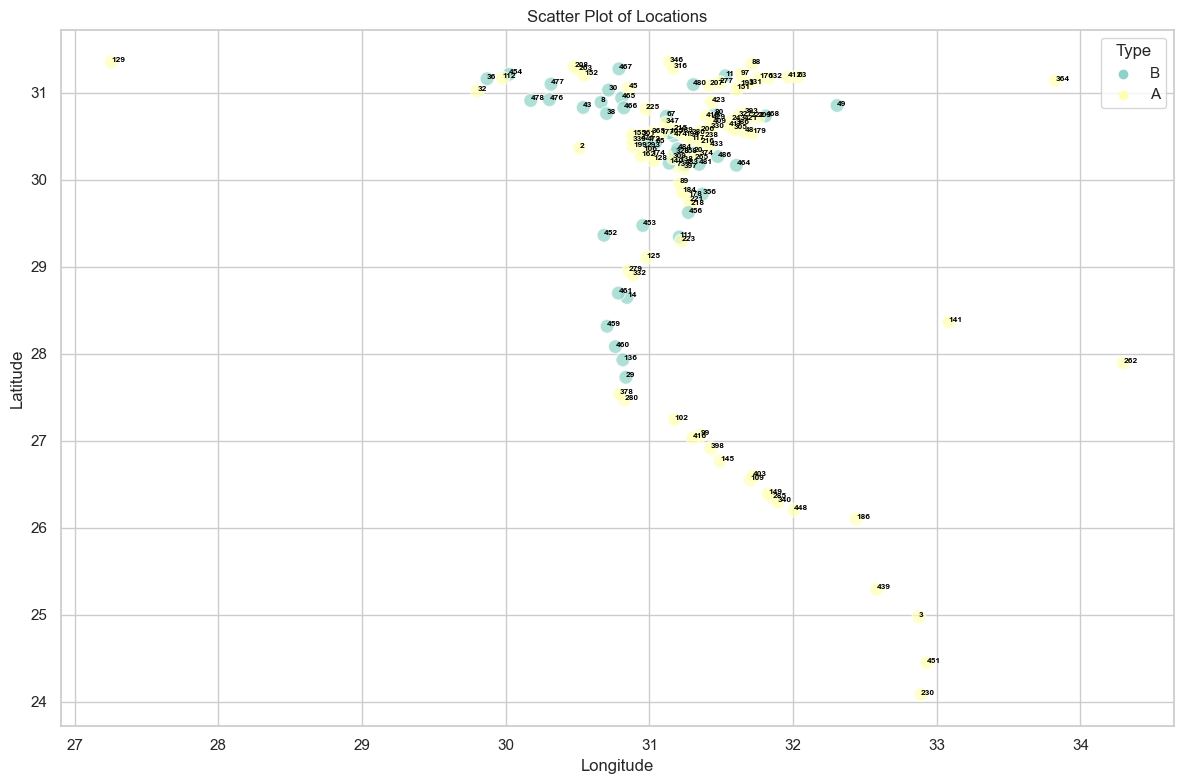

In [221]:
plotDataFrameLongLatWithType(resultDfBallClusterDBSCN,showdistance=True,showNumber=True)

***OPTICS***

OPTICS (Ordering Points To Identify the Clustering Structure) is a density-based clustering algorithm, similar to DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**Core Distance**: It is the minimum value of radius required to classify a given point as a core point. If the given point is not a Core point, then it’s Core Distance is undefined.

**Reachability Distance**: It is defined with respect to another data point q(Let). The Reachability distance between a point p and q is the maximum of the Core Distance of p and the Euclidean Distance(or some other distance metric) between p and q. Note that The Reachability Distance is not defined if q is not a Core point.

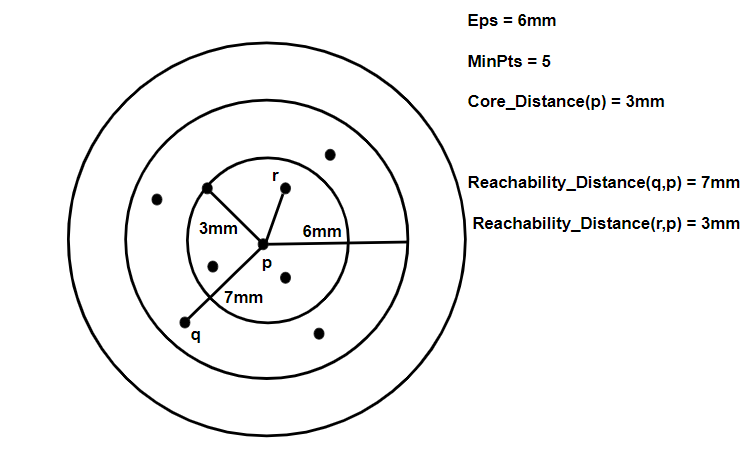


**Cluster extraction**:OPTICS produces a reachability distance plot that can be used to extract clusters at different levels of granularity. This allows for more flexible clustering and can reveal clusters that may not be apparent with a fixed epsilon value in DBSCAN. However, this also requires more manual interpretation and decision-making on the part of the programmer.

**Noise handling**: DBSCAN explicitly distinguishes between core points, boundary points, and noise points, while OPTICS does not explicitly identify noise points. Instead, points with high reachability distances can be considered as potential noise points. However, this also means that OPTICS may be less effective at identifying small clusters that are surrounded by noise points, as these clusters may be merged with the noise points in the reachability distance plot.

**Runtime complexity**: The runtime complexity of OPTICS is generally higher than that of DBSCAN, due to the use of a ***priority queue*** to maintain the reachability distances. However, recent research has proposed optimizations to reduce the computational complexity of OPTICS, making it more scalable for large datasets.

In [222]:
combinedDfBallOPTICS=combinedDfBall

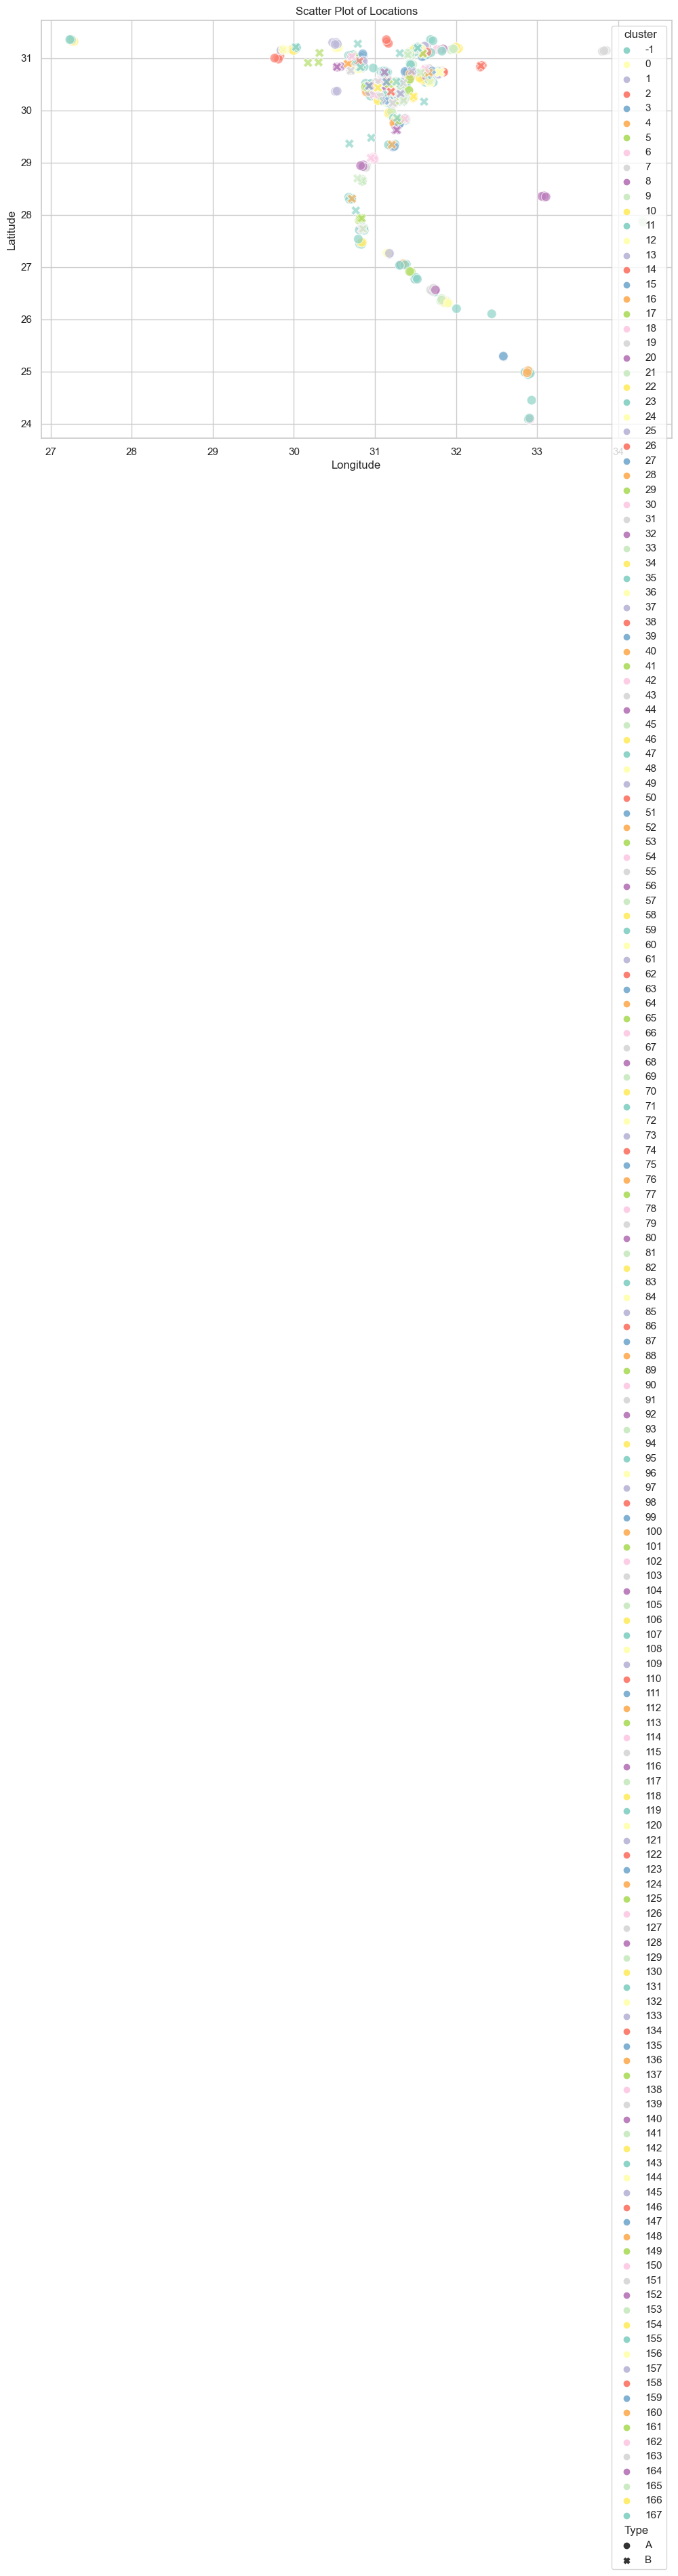

In [223]:
optics = OPTICS(min_samples=2, eps=5, metric='haversine',algorithm="brute")
y_db = optics.fit_predict(srd.fit_transform(np.radians(combinedDfBallOPTICS[["Longitude","Latitude"]])))
combinedDfBallOPTICS['cluster'] = y_db
plotDataFrameLongLatWithType(combinedDfBallOPTICS,clstr=True)

In [224]:
noiseData=combinedDfBallOPTICS[combinedDfBallOPTICS["cluster"]==-1]
startcount=max(combinedDfBallOPTICS[combinedDfBallOPTICS["cluster"]!=-1]["cluster"])
noiseData['cluster'] = range(startcount, (startcount-1)+len(noiseData) + 1)
selectedPoints = selectPoints(pd.concat([combinedDfBallOPTICS[combinedDfBallOPTICS["cluster"]!=-1], noiseData], ignore_index=True))
selectedPoints

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0      58    الشرقية       NaN  30.732944  31.808439              NaN    B   
1    1637    الشرقية       ريف  30.685039  31.780953       282.131111    A   
2    1487    الشرقية       ريف  30.731698  31.843480       369.911111    A   
3     866    الشرقية       ريف  30.721617  31.702214      1066.661111    A   
4      63    الشرقية       NaN  30.722667  31.664328              NaN    B   
..    ...        ...       ...        ...        ...              ...  ...   
283    71   المنوفية       NaN  30.468696  30.934389              NaN    B   
284    72   المنوفية       NaN  30.460861  30.938333              NaN    B   
285    81   المنوفية       NaN  30.428361  31.034500              NaN    B   
286   107   الدقهلية       NaN  31.093528  31.305411              NaN    B   
287   111  القليوبية       NaN  30.226889  31.365677              NaN    B   

     operational_costs  updatedEstimastedSales   Coverage  cluster  
0                15000               96210.857  81210.857        0  
1                25000               89609.278  64609.278        1  
2                25000              103210.140  78210.140        2  
3                25000               59119.196  34119.196        3  
4                15000               54942.319  39942.319        4  
..                 ...                     ...        ...      ...  
283              15000               44173.571  29173.571      283  
284              15000               44173.571  29173.571      284  
285              15000               29824.110  14824.110      285  
286              15000               18315.163   3315.163      286  
287              15000               58432.181  43432.181      287  

[288 rows x 11 columns]

In [225]:
selectedPoints = selectedPoints.sort_values('Coverage', ascending=False).reset_index(drop=True)
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfBallClusterOPTICS = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfBallClusterOPTICS

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1      58    الشرقية       NaN  30.732944  31.808439              NaN    B   
2     116  القليوبية       ريف  30.155107  31.192262     12431.234444    A   
3    1946  القليوبية       ريف  30.284461  31.347094       168.683333    A   
4     765    الشرقية       ريف  30.717965  31.756487      1339.983333    A   
..    ...        ...       ...        ...        ...              ...  ...   
116   643    الشرقية       ريف  30.534998  31.717706      1864.231111    A   
117   695        قنا       ريف  26.103429  32.439087      1614.741111    A   
118   452   المنوفية       ريف  30.516160  30.883343      3224.993333    A   
119  1982      اسيوط       ريف  27.535805  30.793993       158.595556    A   
120    67  كفر الشيخ       حضر  31.309466  31.150495     16794.541111    A   

     operational_costs  updatedEstimastedSales   Coverage  cluster  
0                15000              109193.996  94193.996       61  
1                15000               96210.857  81210.857        0  
2                25000              105264.344  80264.344       52  
3                25000               94386.237  69386.237       64  
4                25000               91977.783  66977.783      200  
..                 ...                     ...        ...      ...  
116              25000               25760.224    760.224      190  
117              25000               25749.606    749.606      192  
118              25000               25649.080    649.080      182  
119              25000               25604.988    604.988      249  
120              25000               25348.356    348.356      122  

[121 rows x 11 columns]

BriefSummary

In [226]:
print(f"The Total Number of Location Selected:{len(resultDfBallClusterOPTICS)}")
print(f"The Total Number of A-Location Selected:{len(resultDfBallClusterOPTICS[resultDfBallClusterOPTICS['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfBallClusterOPTICS[resultDfBallClusterOPTICS['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfBallOPTICS)}")
print(f"The Total Sales Equals:{resultDfBallClusterOPTICS['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfBallClusterOPTICS['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfBallClusterOPTICS['operational_costs'].sum()}")

The Total Number of Location Selected:121
The Total Number of A-Location Selected:82
The Total Number of B-Location Selected:39
The Total Number of Locations Covered by selected:646
The Total Sales Equals:5181672.782999999
The Total Coverage Equals:2546672.7830000003
The Total Costs Equals:2635000


DisplayResults

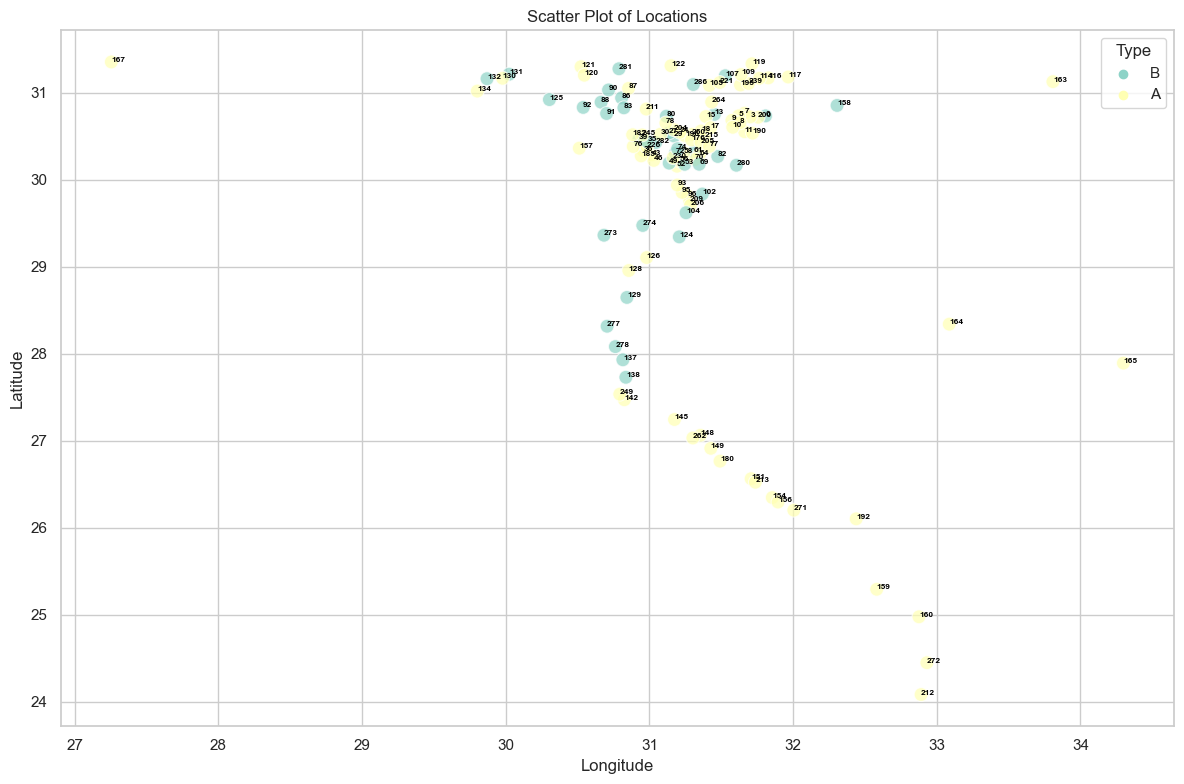

In [227]:
plotDataFrameLongLatWithType(resultDfBallClusterOPTICS,clstr=False,showdistance=True,showNumber=True)

***HDBSCAN***

Estimating densities
We need some method to estimate the density around certain points. One common way to do this is by using “core distance.” This is the distance of a point to its K-th nearest neighbor.

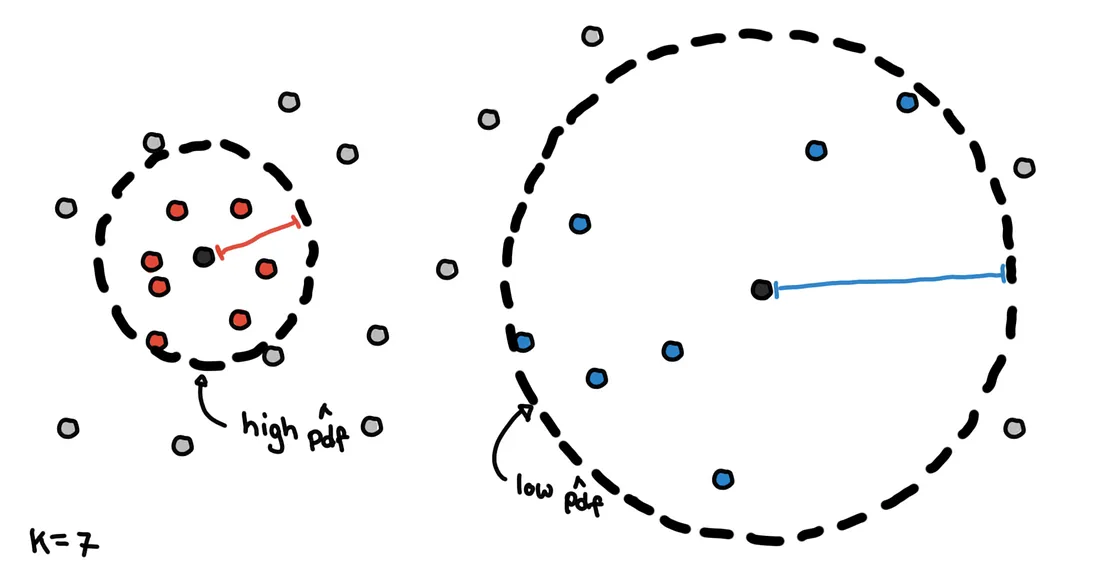

Points in denser regions would have smaller core distances while points in sparser regions would have larger core distances. Core distance is what makes these methods “density-based”.

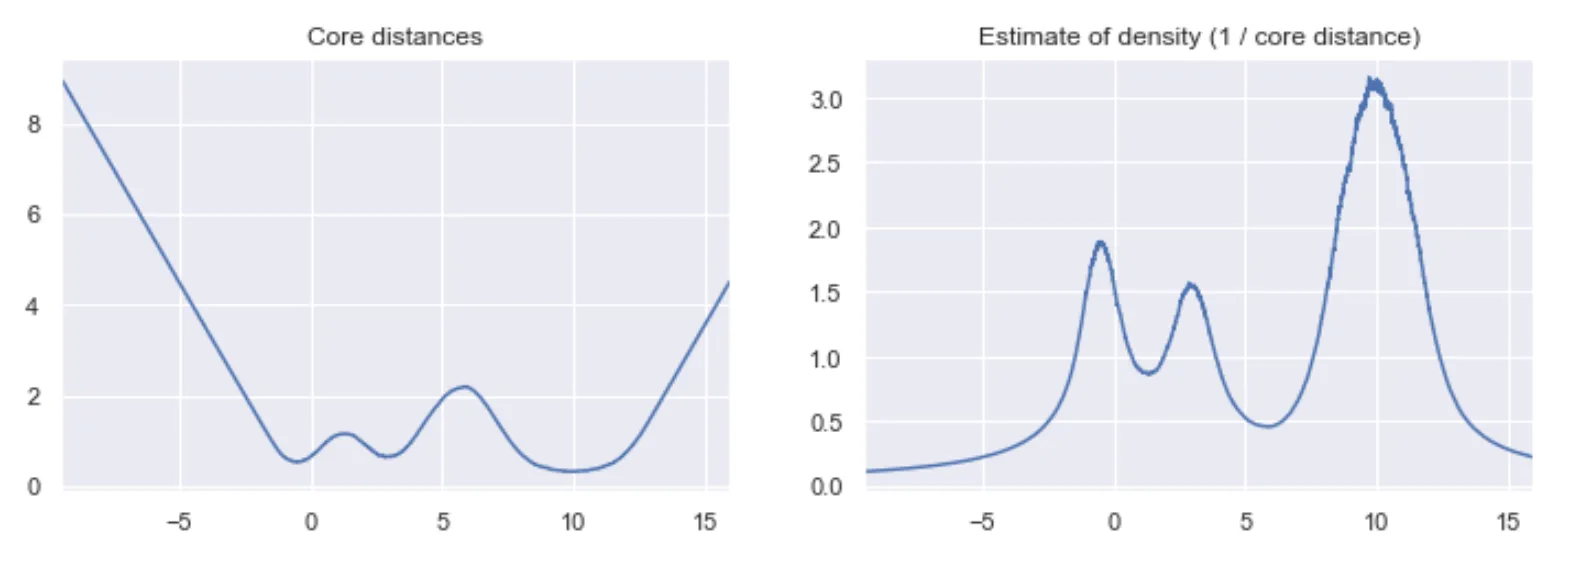

Simple Cluster Selection

One way to select clusters is to pick a global threshold. By getting the points with densities above the threshold, and grouping these points together, we get our clusters.

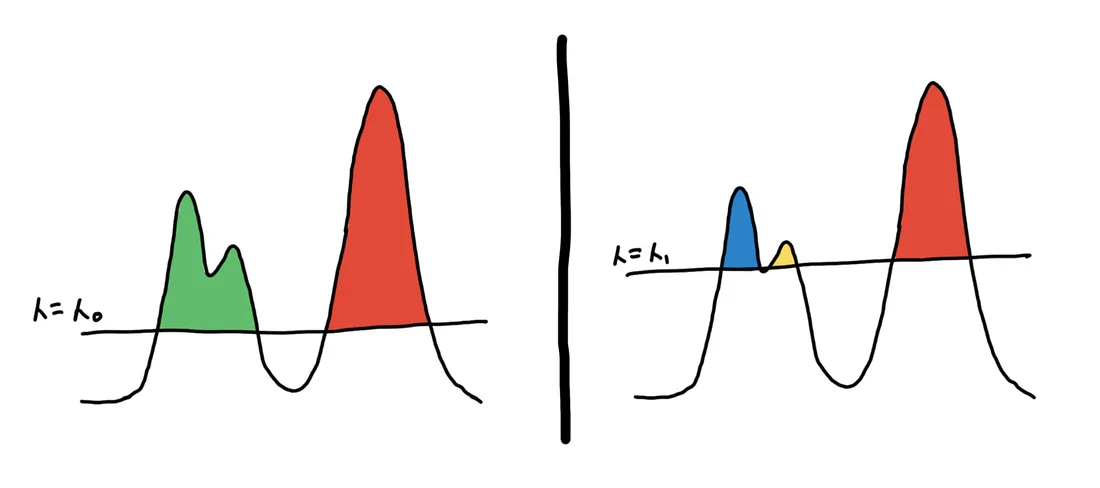

In [228]:
combinedDfBallHDBSCN=combinedDfBall

In [229]:
hdbscn = hdbscan.HDBSCAN(min_cluster_size=2,min_samples=1, cluster_selection_epsilon=5/6371.0, metric='haversine')
y_db = hdbscn.fit_predict(srd.fit_transform(np.radians(combinedDfBallHDBSCN[["Longitude","Latitude"]])))
combinedDfBallHDBSCN['cluster'] = y_db

In [230]:
noiseData=combinedDfBallHDBSCN[combinedDfBallHDBSCN["cluster"]==-1]
startcount=max(combinedDfBallHDBSCN[combinedDfBallHDBSCN["cluster"]!=-1]["cluster"])
noiseData['cluster'] = range(startcount, (startcount-1)+len(noiseData) + 1)
selectedPoints = selectPoints(pd.concat([combinedDfBallHDBSCN[combinedDfBallHDBSCN["cluster"]!=-1], noiseData], ignore_index=True))
selectedPoints

ID           Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     317    مرسى مطروح       حضر  31.352412  27.255389      5367.276667    A   
1     112    مرسى مطروح       حضر  31.327339  27.265570     12714.126667    A   
2    1194    جنوب سيناء       حضر  27.892750  34.298750       578.293333    A   
3      41  البحر الاحمر       حضر  28.340011  33.086865     21800.420000    A   
4      30    شمال سيناء       حضر  31.126209  33.808316     25193.351111    A   
..    ...           ...       ...        ...        ...              ...  ...   
233    46       القاهرة       NaN  30.164937  31.337363              NaN    B   
234    51       القاهرة       NaN  30.165917  31.605466              NaN    B   
235    56     كفر الشيخ       NaN  31.274111  30.788123              NaN    B   
236   107      الدقهلية       NaN  31.093528  31.305411              NaN    B   
237   111     القليوبية       NaN  30.226889  31.365677              NaN    B   

     operational_costs  updatedEstimastedSales   Coverage  cluster  
0                25000               84420.660  59420.660        0  
1                25000               84420.660  59420.660        1  
2                25000               42917.283  17917.283        2  
3                25000               29658.218   4658.218        3  
4                25000               27226.639   2226.639        4  
..                 ...                     ...        ...      ...  
233              15000               19896.361   4896.361      233  
234              15000               17900.754   2900.754      234  
235              15000               18797.744   3797.744      235  
236              15000               18315.163   3315.163      236  
237              15000               58432.181  43432.181      237  

[238 rows x 11 columns]

In [231]:
selectedPoints = selectedPoints.sort_values('Coverage', ascending=False).reset_index(drop=True)
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfBallClusterHDBSCN = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfBallClusterHDBSCN

ID        Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0     129  القليوبية       NaN  30.318393  31.310492              NaN    B   
1      58    الشرقية       NaN  30.732944  31.808439              NaN    B   
2     116  القليوبية       ريف  30.155107  31.192262     12431.234444    A   
3    1946  القليوبية       ريف  30.284461  31.347094       168.683333    A   
4     765    الشرقية       ريف  30.717965  31.756487      1339.983333    A   
..    ...        ...       ...        ...        ...              ...  ...   
114   643    الشرقية       ريف  30.534998  31.717706      1864.231111    A   
115   695        قنا       ريف  26.103429  32.439087      1614.741111    A   
116   452   المنوفية       ريف  30.516160  30.883343      3224.993333    A   
117  1982      اسيوط       ريف  27.535805  30.793993       158.595556    A   
118    67  كفر الشيخ       حضر  31.309466  31.150495     16794.541111    A   

     operational_costs  updatedEstimastedSales   Coverage  cluster  
0                15000              109193.996  94193.996      146  
1                15000               96210.857  81210.857       87  
2                25000              105264.344  80264.344      154  
3                25000               94386.237  69386.237      140  
4                25000               91977.783  66977.783      182  
..                 ...                     ...        ...      ...  
114              25000               25760.224    760.224      176  
115              25000               25749.606    749.606      178  
116              25000               25649.080    649.080      169  
117              25000               25604.988    604.988      217  
118              25000               25348.356    348.356       38  

[119 rows x 11 columns]

DisplayResults

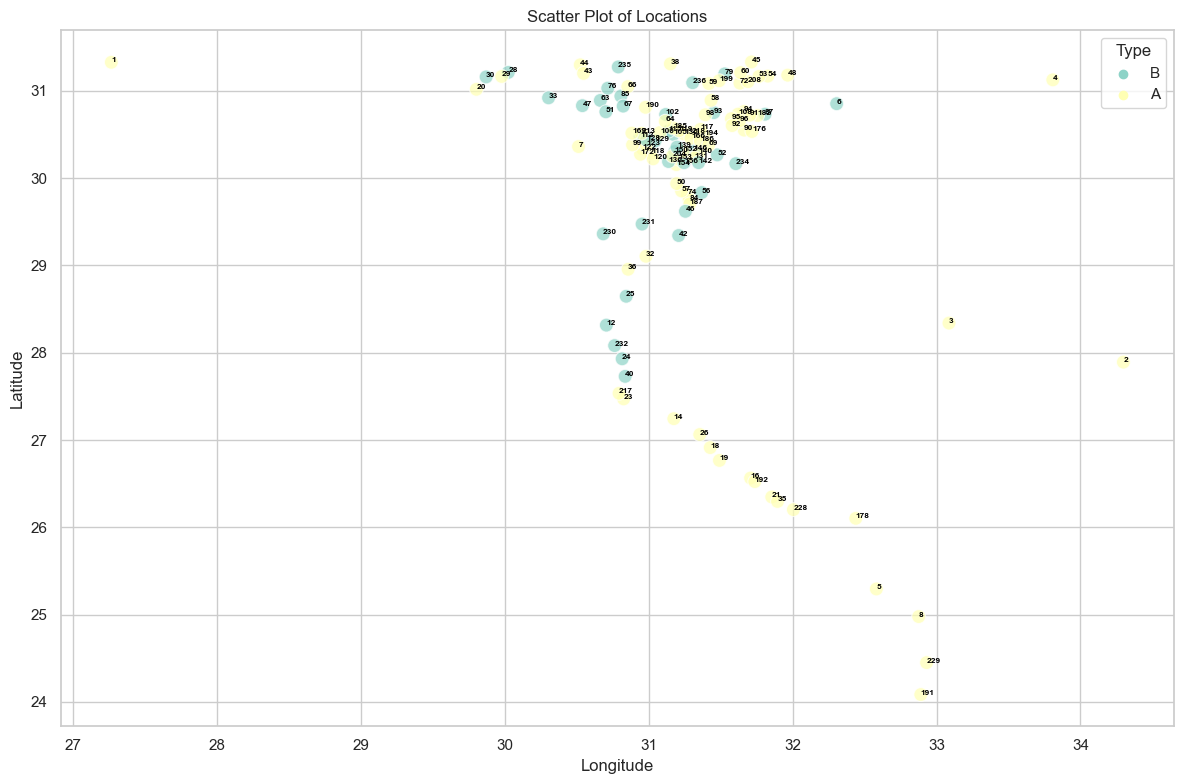

In [232]:
plotDataFrameLongLatWithType(resultDfBallClusterHDBSCN,clstr=False,showdistance=True,showNumber=True)

BriefSummary

In [233]:
print(f"The Total Number of Location Selected:{len(resultDfBallClusterHDBSCN)}")
print(f"The Total Number of A-Location Selected:{len(resultDfBallClusterHDBSCN[resultDfBallClusterHDBSCN['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfBallClusterHDBSCN[resultDfBallClusterHDBSCN['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfBallHDBSCN)}")
print(f"The Total Sales Equals:{resultDfBallClusterHDBSCN['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfBallClusterHDBSCN['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfBallClusterHDBSCN['operational_costs'].sum()}")

The Total Number of Location Selected:119
The Total Number of A-Location Selected:80
The Total Number of B-Location Selected:39
The Total Number of Locations Covered by selected:646
The Total Sales Equals:5101434.974999999
The Total Coverage Equals:2516434.975000001
The Total Costs Equals:2585000


OptionOneResult

In [234]:
optionOneDFResult=pd.DataFrame({
    "choices":["HDBSCAN","DBSCAN","OPTICS","BallTree","Brute"],
    "# of-Loc":[len(resultDfBallClusterHDBSCN),len(resultDfBallClusterDBSCN),len(resultDfBallClusterOPTICS),len(resultDfBall),len(resultDfBrute)],
    "# of-A-Loc":[len(resultDfBallClusterHDBSCN[resultDfBallClusterHDBSCN['Type']=='A']),len(resultDfBallClusterDBSCN[resultDfBallClusterDBSCN['Type']=='A']),len(resultDfBallClusterOPTICS[resultDfBallClusterOPTICS['Type']=='A']),len(resultDfBall[resultDfBall['Type']=='A']),len(resultDfBrute[resultDfBrute['Type']=='A'])],
    "# of-B-Loc":[len(resultDfBallClusterHDBSCN[resultDfBallClusterHDBSCN['Type']=='B']),len(resultDfBallClusterDBSCN[resultDfBallClusterDBSCN['Type']=='B']),len(resultDfBallClusterOPTICS[resultDfBallClusterOPTICS['Type']=='B']),len(resultDfBall[resultDfBall['Type']=='B']),len(resultDfBrute[resultDfBrute['Type']=='B'])],
    "# of-LocCover":[len(combinedDfBallHDBSCN),len(combinedDfBallDBSCN),len(combinedDfBallOPTICS),len(combinedDfBall),len(combinedDfBrute)],
    "TotalSales":[round(elm,3) for elm in [resultDfBallClusterHDBSCN['updatedEstimastedSales'].sum(),resultDfBallClusterDBSCN['updatedEstimastedSales'].sum(),resultDfBallClusterOPTICS['updatedEstimastedSales'].sum(),resultDfBall['updatedEstimastedSales'].sum(),resultDfBrute['updatedEstimastedSales'].sum()]],
    'TotalCoverage':[round(elm,3) for elm in [resultDfBallClusterHDBSCN['Coverage'].sum(),resultDfBallClusterDBSCN['Coverage'].sum(),resultDfBallClusterOPTICS['Coverage'].sum(),resultDfBall['Coverage'].sum(),resultDfBrute['Coverage'].sum()]],
    "TotalCosts":[resultDfBallClusterHDBSCN['operational_costs'].sum(),resultDfBallClusterDBSCN['operational_costs'].sum(),resultDfBallClusterOPTICS['operational_costs'].sum(),resultDfBall['operational_costs'].sum(),resultDfBrute['operational_costs'].sum()],
})

In [235]:
optionOneDFResult

choices  # of-Loc  # of-A-Loc  # of-B-Loc  # of-LocCover   TotalSales  \
0   HDBSCAN       119          80          39            646  5101434.975   
1    DBSCAN       138          96          42            646  5701418.605   
2    OPTICS       121          82          39            646  5181672.783   
3  BallTree       136          94          42            646  5579939.260   
4     Brute       137          94          43            647  5601378.195   

   TotalCoverage  TotalCosts  
0    2516434.975     2585000  
1    2671418.605     3030000  
2    2546672.783     2635000  
3    2599939.260     2980000  
4    2606378.195     2995000

### ***Option 2***

In [236]:
combinedDFOption2=pd.concat([dataFrameTypeA, dataFrameTypeB], ignore_index=True)

In [237]:
combinedDFOption2

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0       1      الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1       2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2       3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3       4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
4       5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
...   ...          ...       ...        ...        ...              ...  ...   
2665  130    القليوبية       NaN  30.186000  31.353272              NaN    B   
2666  131    القليوبية       NaN  30.138000  31.220216              NaN    B   
2667  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   
2668  133       السويس       NaN  29.985253  32.507537              NaN    B   
2669  134       السويس       NaN  29.974776  32.580658              NaN    B   

      operational_costs  updatedEstimastedSales  
0                 25000               96084.883  
1                 25000               57434.150  
2                 25000               51029.819  
3                 25000               63934.114  
4                 25000               68756.226  
...                 ...                     ...  
2665              15000               30255.746  
2666              15000               47367.362  
2667              15000               28021.987  
2668              15000               12891.747  
2669              15000                   0.000  

[2670 rows x 9 columns]

***DBSCAN***

In [238]:
combinedDfDBSCNOPT2=combinedDFOption2

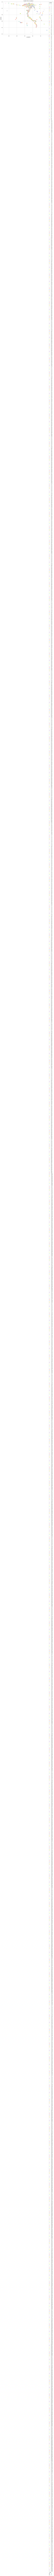

In [239]:
srd=MinMaxScaler()
db = DBSCAN(eps=6/6371.0, min_samples=1, metric='haversine',algorithm='brute')  
y_db = db.fit_predict(srd.fit_transform(np.radians(combinedDfDBSCNOPT2[["Longitude","Latitude"]])))
combinedDfDBSCNOPT2['cluster'] = y_db
plotDataFrameLongLatWithType(combinedDfDBSCNOPT2,clstr=True)

In [240]:
combinedDfDBSCNOPT2['updatedEstimastedSales'] = combinedDfDBSCNOPT2.groupby('cluster')['Estimated_Sales'].transform('sum')

In [241]:
combinedDfDBSCNOPT2

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0       1      الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1       2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2       3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3       4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
4       5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
...   ...          ...       ...        ...        ...              ...  ...   
2665  130    القليوبية       NaN  30.186000  31.353272              NaN    B   
2666  131    القليوبية       NaN  30.138000  31.220216              NaN    B   
2667  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   
2668  133       السويس       NaN  29.985253  32.507537              NaN    B   
2669  134       السويس       NaN  29.974776  32.580658              NaN    B   

      operational_costs  updatedEstimastedSales  cluster  
0                 25000            85931.800000        0  
1                 25000            54690.637778        1  
2                 25000            42379.708889        2  
3                 25000            56644.472222        3  
4                 25000            41380.507778        4  
...                 ...                     ...      ...  
2665              15000             3204.828889      396  
2666              15000            31718.676667       12  
2667              15000            16944.621111       60  
2668              15000             2082.665556      665  
2669              15000                0.000000     2194  

[2670 rows x 10 columns]

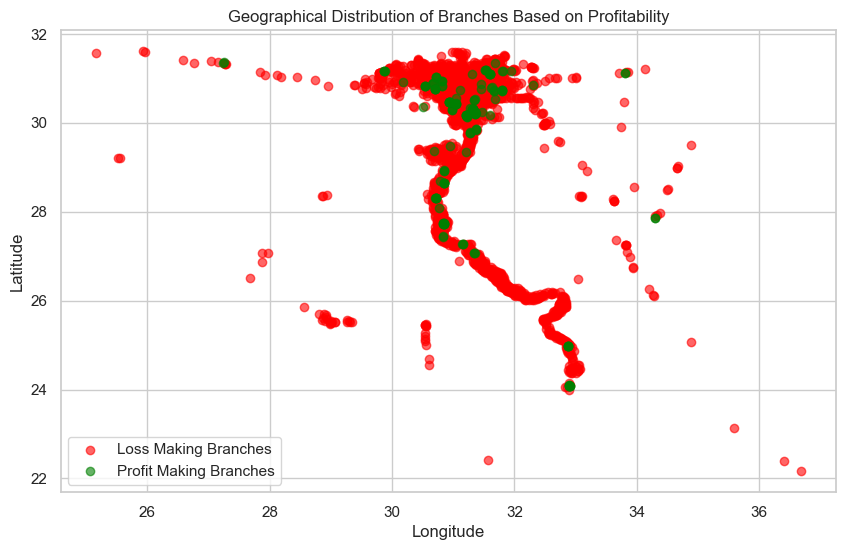

In [242]:
displayRemovedLocations(combinedDfDBSCNOPT2)

In [243]:
combinedDfDBSCNOPT2=combinedDfDBSCNOPT2[combinedDfDBSCNOPT2["updatedEstimastedSales"]>combinedDfDBSCNOPT2["operational_costs"]]

In [244]:
combinedDfDBSCNOPT2

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0       1      الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1       2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2       3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3       4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
4       5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
...   ...          ...       ...        ...        ...              ...  ...   
2660  125    القليوبية       NaN  30.310222  31.323466              NaN    B   
2663  128    القليوبية       NaN  30.145500  31.215355              NaN    B   
2664  129    القليوبية       NaN  30.318393  31.310492              NaN    B   
2666  131    القليوبية       NaN  30.138000  31.220216              NaN    B   
2667  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   

      operational_costs  updatedEstimastedSales  cluster  
0                 25000            85931.800000        0  
1                 25000            54690.637778        1  
2                 25000            42379.708889        2  
3                 25000            56644.472222        3  
4                 25000            41380.507778        4  
...                 ...                     ...      ...  
2660              15000            65058.061789       20  
2663              15000            31718.676667       12  
2664              15000            65058.061789       20  
2666              15000            31718.676667       12  
2667              15000            16944.621111       60  

[169 rows x 10 columns]

In [245]:
combinedDfDBSCNOPT2["Coverage"]=combinedDfDBSCNOPT2["updatedEstimastedSales"]-combinedDfDBSCNOPT2["operational_costs"]

In [246]:
selectedPoints = selectPoints(combinedDfDBSCNOPT2)
selectedPoints = selectedPoints.sort_values('Coverage', ascending=False).reset_index(drop=True)
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfDBSCNOPT2 = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfDBSCNOPT2

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0    57      الشرقية       NaN  30.733709  31.791613              NaN    B   
1    18        أسوان       حضر  24.089784  32.898154     30039.402222    A   
2   123    القليوبية       NaN  30.313824  31.318385              NaN    B   
3    30     المنيا         NaN  28.647222  30.843517              NaN    B   
4    33     المنيا         NaN  28.316419  30.705637              NaN    B   
5    63      الشرقية       NaN  30.722667  31.664328              NaN    B   
6   115    القليوبية       NaN  30.180428  31.217045              NaN    B   
7     4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
8    62      الشرقية       NaN  30.523139  31.348689              NaN    B   
9     2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
10   93      البحيرة       NaN  30.890535  30.663745              NaN    B   
11   77     المنوفية       NaN  30.298833  30.983217              NaN    B   
12   29     المنيا         NaN  27.736193  30.834816              NaN    B   
13  105     الدقهلية       NaN  31.194083  31.528133              NaN    B   
14   53      الغربية       NaN  30.939739  30.806615              NaN    B   
15    3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
16    5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
17    7    القليوبية       ريف  30.334697  31.268586     40289.102156    A   
18  102     الدقهلية       NaN  31.090019  31.597546              NaN    B   
19   92      البحيرة       NaN  30.762731  30.694217              NaN    B   
20   98      البحيرة       NaN  30.830361  30.539272              NaN    B   
21  113    القليوبية       NaN  30.245453  31.353542              NaN    B   
22   22        اسيوط       حضر  27.061354  31.340125     27662.900000    A   
23   96      البحيرة       NaN  31.030694  30.715550              NaN    B   
24   66      الشرقية       NaN  30.791750  31.620855              NaN    B   
25   44     بني سويف       حضر  28.925050  30.855897     20982.414444    A   
26    9   الاسكندرية       NaN  31.159778  29.869967              NaN    B   
27   10   جنوب سيناء       حضر  27.860291  34.303116     34468.973333    A   
28   61      الشرقية       NaN  30.535955  31.677756              NaN    B   
29   55      الغربية       NaN  30.729556  31.117917              NaN    B   
30   45      القاهرة       NaN  30.469000  30.939133              NaN    B   
31   16     الدقهلية       حضر  31.166643  31.803276     30836.737778    A   
32    4       الفيوم       NaN  29.361996  30.683888              NaN    B   
33   52      الغربية       NaN  30.824112  30.810771              NaN    B   
34   20        اسيوط       حضر  27.443933  30.830140     29299.514444    A   
35   60      الشرقية       NaN  30.750426  31.452409              NaN    B   
36   17     الدقهلية       حضر  30.881879  31.454996     30526.830000    A   
37   34     المنيا         NaN  28.082083  30.763189              NaN    B   
38   70       الجيزة       ريف  29.775070  31.267214     16106.003333    A   
39   19        دمياط       حضر  31.354685  31.685219     29965.090000    A   
40   35     المنيا         NaN  28.696693  30.784010              NaN    B   
41   68     المنوفية       NaN  30.426583  31.044210              NaN    B   
42    6       الفيوم       NaN  29.474248  30.953917              NaN    B   
43  100      البحيرة       NaN  30.910763  30.173929              NaN    B   
44   51      القاهرة       NaN  30.165917  31.605466              NaN    B   
45   84     المنوفية       NaN  30.549361  31.036855              NaN    B   
46   38        اسيوط       حضر  27.264926  31.154670     22491.631111    A   
47  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   
48   30   شمال سيناء       حضر  31.126209  33.808316     25193.351111    A   
49   28     الدقهلية       حضر  31.159029  31.936320     25787.155556    A   
50  107     الدقهلية       

DisplayResults

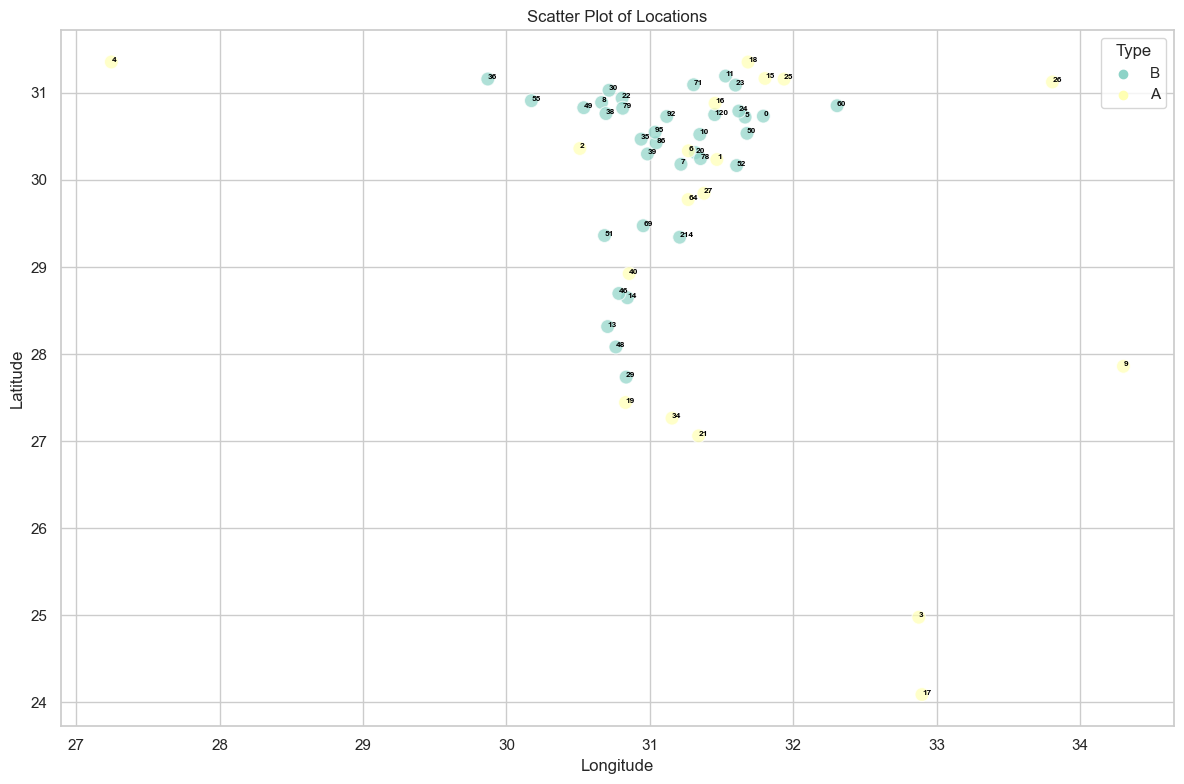

In [247]:
plotDataFrameLongLatWithType(resultDfDBSCNOPT2,showdistance=True,showNumber=True)

BriefSummary

In [248]:
print(f"The Total Number of Location Selected:{len(resultDfDBSCNOPT2)}")
print(f"The Total Number of A-Location Selected:{len(resultDfDBSCNOPT2[resultDfDBSCNOPT2['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfDBSCNOPT2[resultDfDBSCNOPT2['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfDBSCNOPT2)}")
print(f"The Total Sales Equals:{resultDfDBSCNOPT2['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfDBSCNOPT2['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfDBSCNOPT2['operational_costs'].sum()}")

The Total Number of Location Selected:53
The Total Number of A-Location Selected:18
The Total Number of B-Location Selected:35
The Total Number of Locations Covered by selected:169
The Total Sales Equals:1794523.101977778
The Total Coverage Equals:819523.1019777778
The Total Costs Equals:975000


***OPTICS***

In [249]:
combinedDfOPTICSOPT2=combinedDFOption2

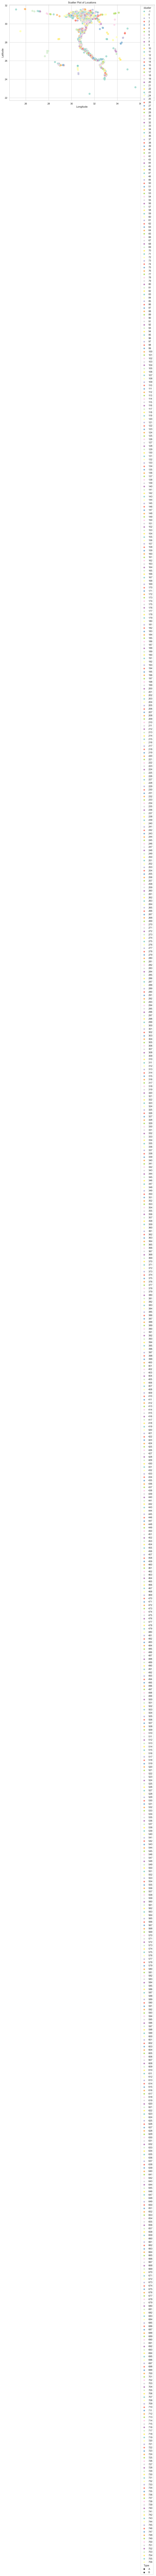

In [250]:
optics = OPTICS(min_samples=2, eps=5, metric='haversine',algorithm="brute")
y_db = optics.fit_predict(srd.fit_transform(np.radians(combinedDfOPTICSOPT2[["Longitude","Latitude"]])))
combinedDfOPTICSOPT2['cluster'] = y_db
plotDataFrameLongLatWithType(combinedDfOPTICSOPT2,clstr=True)

In [251]:
combinedDfOPTICSOPT2['updatedEstimastedSales'] = combinedDfOPTICSOPT2.groupby('cluster')['Estimated_Sales'].transform('sum')

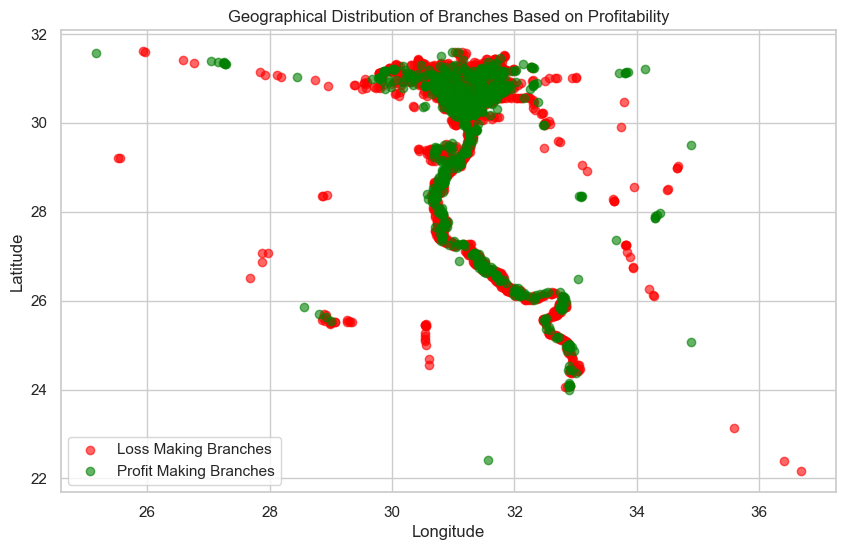

In [252]:
displayRemovedLocations(combinedDfOPTICSOPT2)

In [253]:
combinedDfOPTICSOPT2=combinedDfOPTICSOPT2[combinedDfOPTICSOPT2["updatedEstimastedSales"]>combinedDfOPTICSOPT2["operational_costs"]]

In [254]:
combinedDfOPTICSOPT2

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0       1      الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1       2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2       3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3       4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
4       5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
...   ...          ...       ...        ...        ...              ...  ...   
2660  125    القليوبية       NaN  30.310222  31.323466              NaN    B   
2663  128    القليوبية       NaN  30.145500  31.215355              NaN    B   
2664  129    القليوبية       NaN  30.318393  31.310492              NaN    B   
2666  131    القليوبية       NaN  30.138000  31.220216              NaN    B   
2667  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   

      operational_costs  updatedEstimastedSales  cluster  
0                 25000            85931.800000        0  
1                 25000            57434.150000      690  
2                 25000            51029.818889      721  
3                 25000            62155.374444      682  
4                 25000            46747.784444      728  
...                 ...                     ...      ...  
2660              15000            46479.968456      128  
2663              15000            31718.676667      114  
2664              15000            18110.285556      129  
2666              15000            31718.676667      114  
2667              15000            31237.639367      710  

[708 rows x 10 columns]

In [255]:
combinedDfOPTICSOPT2["Coverage"]=combinedDfOPTICSOPT2["updatedEstimastedSales"]-combinedDfOPTICSOPT2["operational_costs"]

In [256]:
noiseData=combinedDfOPTICSOPT2[combinedDfOPTICSOPT2["cluster"]==-1]
startcount=max(combinedDfOPTICSOPT2[combinedDfOPTICSOPT2["cluster"]!=-1]["cluster"])
noiseData['cluster'] = range(startcount, (startcount-1)+len(noiseData) + 1)
selectedPoints = selectPoints(pd.concat([combinedDfOPTICSOPT2[combinedDfOPTICSOPT2["cluster"]!=-1], noiseData], ignore_index=True))
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfOPTICSOPT2 = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfOPTICSOPT2

ID       Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0      57   الشرقية       NaN  30.733709  31.791613              NaN    B   
1      63   الشرقية       NaN  30.722667  31.664328              NaN    B   
2      60   الشرقية       NaN  30.750426  31.452409              NaN    B   
3      62   الشرقية       NaN  30.523139  31.348689              NaN    B   
4      84  المنوفية       NaN  30.549361  31.036855              NaN    B   
..    ...       ...       ...        ...        ...              ...  ...   
344  2492  بني سويف       ريف  29.029384  31.082819        40.915556    A   
345  2507     أسوان       حضر  23.979483  32.896105        37.955556    A   
346  2509       قنا       ريف  26.194544  32.554853        37.046667    A   
347  2511    المنيا       ريف  28.454434  30.668412        36.696667    A   
348    43  المنيا         NaN  28.093250  30.814605              NaN    B   

     operational_costs  updatedEstimastedSales  cluster       Coverage  
0                15000            85931.800000        0   70931.800000  
1                15000            53305.933333       10   38305.933333  
2                15000            22111.735556       36    7111.735556  
3                15000            46646.990000       51   31646.990000  
4                15000            17693.730000       99    2693.730000  
..                 ...                     ...      ...            ...  
344              25000           817101.511389     1217  792101.511389  
345              25000           817101.511389     1219  792101.511389  
346              25000           817101.511389     1220  792101.511389  
347              25000           817101.511389     1221  792101.511389  
348              15000           817101.511389     1227  802101.511389  

[349 rows x 11 columns]

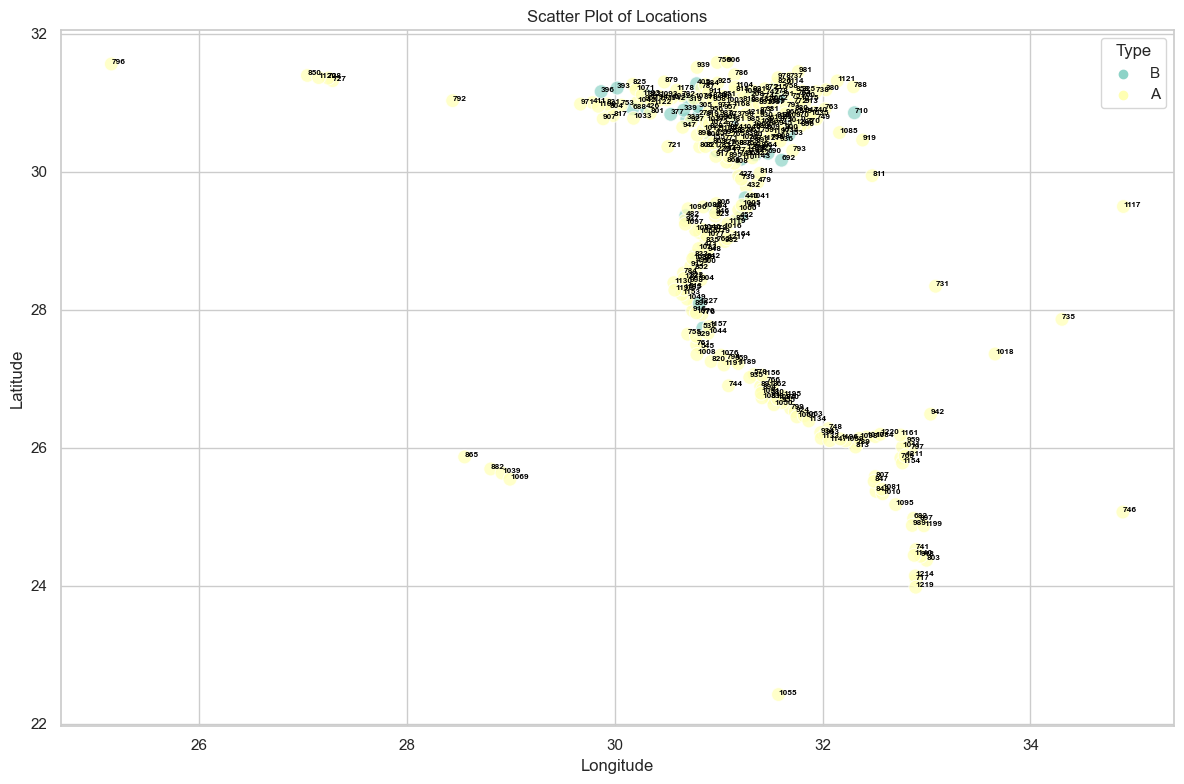

In [257]:
plotDataFrameLongLatWithType(resultDfOPTICSOPT2,showdistance=True,showNumber=True)

In [258]:
print(f"The Total Number of Location Selected:{len(resultDfOPTICSOPT2)}")
print(f"The Total Number of A-Location Selected:{len(resultDfOPTICSOPT2[resultDfOPTICSOPT2['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfOPTICSOPT2[resultDfOPTICSOPT2['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfOPTICSOPT2)}")
print(f"The Total Sales Equals:{resultDfOPTICSOPT2['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfOPTICSOPT2['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfOPTICSOPT2['operational_costs'].sum()}")

The Total Number of Location Selected:349
The Total Number of A-Location Selected:311
The Total Number of B-Location Selected:38
The Total Number of Locations Covered by selected:708
The Total Sales Equals:238218585.73551106
The Total Coverage Equals:229873585.73551106
The Total Costs Equals:8345000


***HDBSCAN***

In [259]:
combinedDfHDBSCNOPT2=combinedDFOption2

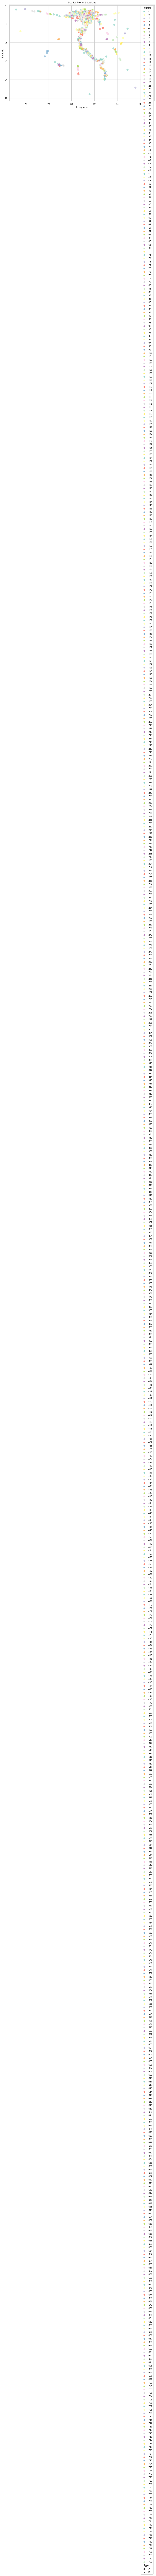

In [260]:
hdbscn = hdbscan.HDBSCAN(min_cluster_size=2,min_samples=1, cluster_selection_epsilon=5/6371.0, metric='haversine')
y_db = hdbscn.fit_predict(srd.fit_transform(np.radians(combinedDfHDBSCNOPT2[["Longitude","Latitude"]])))
combinedDfHDBSCNOPT2['cluster'] = y_db
plotDataFrameLongLatWithType(combinedDfHDBSCNOPT2,clstr=True)

In [261]:
combinedDfHDBSCNOPT2['updatedEstimastedSales'] = combinedDfHDBSCNOPT2.groupby('cluster')['Estimated_Sales'].transform('sum')

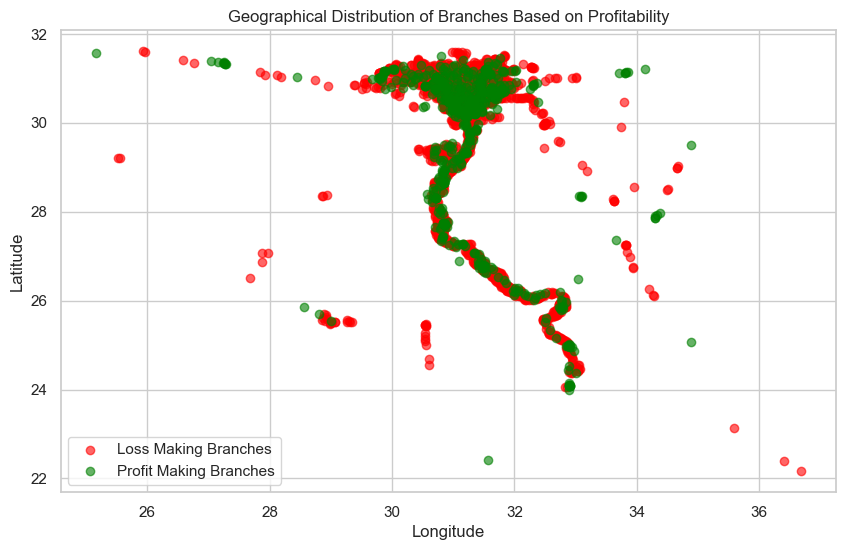

In [262]:
displayRemovedLocations(combinedDfHDBSCNOPT2)

In [263]:
combinedDfHDBSCNOPT2=combinedDfHDBSCNOPT2[combinedDfHDBSCNOPT2["updatedEstimastedSales"]>combinedDfHDBSCNOPT2["operational_costs"]]

In [264]:
combinedDfHDBSCNOPT2

ID          Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0       1      الشرقية       حضر  30.727543  31.793701     72021.026667    A   
1       2      القاهرة       حضر  30.235685  31.467567     54690.637778    A   
2       3     المنوفية       حضر  30.361963  30.512031     42379.708889    A   
3       4        أسوان       حضر  24.977806  32.875934     42377.312222    A   
4       5   مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
...   ...          ...       ...        ...        ...              ...  ...   
2660  125    القليوبية       NaN  30.310222  31.323466              NaN    B   
2663  128    القليوبية       NaN  30.145500  31.215355              NaN    B   
2664  129    القليوبية       NaN  30.318393  31.310492              NaN    B   
2666  131    القليوبية       NaN  30.138000  31.220216              NaN    B   
2667  132  الاسماعيلية       NaN  30.852917  32.306078              NaN    B   

      operational_costs  updatedEstimastedSales  cluster  
0                 25000            91445.203333      593  
1                 25000            57434.150000       56  
2                 25000            51029.818889       31  
3                 25000            62155.374444      101  
4                 25000            46747.784444       28  
...                 ...                     ...      ...  
2660              15000            66996.411789      669  
2663              15000            31718.676667      674  
2664              15000            66996.411789      669  
2666              15000            31718.676667      674  
2667              15000            31237.639367       42  

[598 rows x 10 columns]

In [265]:
combinedDfHDBSCNOPT2["Coverage"]=combinedDfHDBSCNOPT2["updatedEstimastedSales"]-combinedDfHDBSCNOPT2["operational_costs"]

In [266]:
noiseData=combinedDfHDBSCNOPT2[combinedDfHDBSCNOPT2["cluster"]==-1]
startcount=max(combinedDfHDBSCNOPT2[combinedDfHDBSCNOPT2["cluster"]!=-1]["cluster"])
noiseData['cluster'] = range(startcount, (startcount-1)+len(noiseData) + 1)
selectedPoints = selectPoints(pd.concat([combinedDfHDBSCNOPT2[combinedDfHDBSCNOPT2["cluster"]!=-1], noiseData], ignore_index=True))
indicesWithinDistance=filterRowsWithinDistance(selectedPoints)
resultDfHDBSCNOPT2 = selectedPoints.loc[indicesWithinDistance].reset_index(drop=True)
resultDfHDBSCNOPT2

ID           Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0      30    شمال سيناء       حضر  31.126209  33.808316     25193.351111    A   
1      41  البحر الاحمر       حضر  28.340011  33.086865     21800.420000    A   
2      10    جنوب سيناء       حضر  27.860291  34.303116     34468.973333    A   
3      77    مرسى مطروح       حضر  31.318053  27.287814     15664.434444    A   
4       5    مرسى مطروح       حضر  31.355745  27.244068     40826.774444    A   
..    ...           ...       ...        ...        ...              ...  ...   
289  2430       الشرقية       ريف  30.693489  31.739608        50.696667    A   
290  2488      الدقهلية       ريف  30.834214  31.263532        41.683333    A   
291  2507         أسوان       حضر  23.979483  32.896105        37.955556    A   
292  2511        المنيا       ريف  28.454434  30.668412        36.696667    A   
293    43      المنيا         NaN  28.093250  30.814605              NaN    B   

     operational_costs  updatedEstimastedSales  cluster       Coverage  
0                25000            27797.405556       12    2797.405556  
1                25000            29658.217778       20    4658.217778  
2                25000            42950.647778       22   17950.647778  
3                25000            37672.875556       27   12672.875556  
4                25000            46747.784444       28   21747.784444  
..                 ...                     ...      ...            ...  
289              25000           624781.123611     1042  599781.123611  
290              25000           624781.123611     1046  599781.123611  
291              25000           624781.123611     1048  599781.123611  
292              25000           624781.123611     1049  599781.123611  
293              15000           624781.123611     1052  609781.123611  

[294 rows x 11 columns]

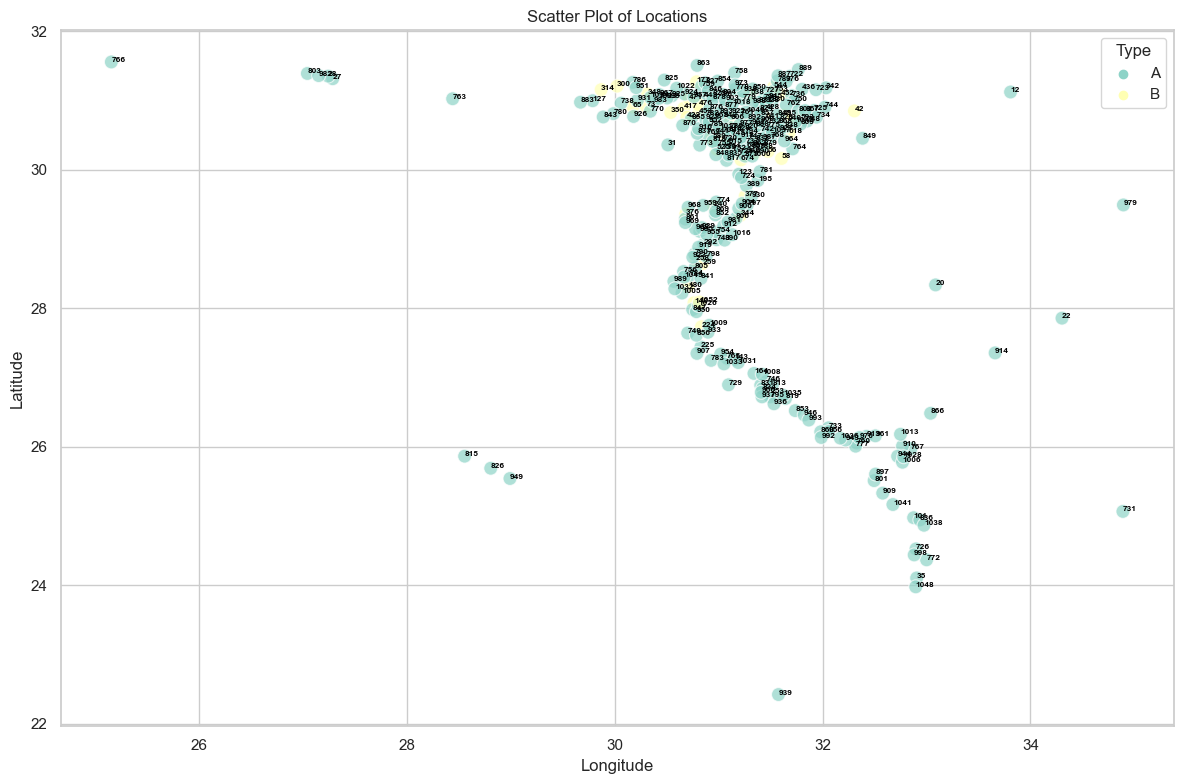

In [267]:
plotDataFrameLongLatWithType(resultDfHDBSCNOPT2,showdistance=True,showNumber=True)

In [268]:
print(f"The Total Number of Location Selected:{len(resultDfHDBSCNOPT2)}")
print(f"The Total Number of A-Location Selected:{len(resultDfHDBSCNOPT2[resultDfHDBSCNOPT2['Type']=='A'])}")
print(f"The Total Number of B-Location Selected:{len(resultDfHDBSCNOPT2[resultDfHDBSCNOPT2['Type']=='B'])}")
print(f"The Total Number of Locations Covered by selected:{len(combinedDfHDBSCNOPT2)}")
print(f"The Total Sales Equals:{resultDfHDBSCNOPT2['updatedEstimastedSales'].sum()}")
print(f"The Total Coverage Equals:{resultDfHDBSCNOPT2['Coverage'].sum()}")
print(f"The Total Costs Equals:{resultDfHDBSCNOPT2['operational_costs'].sum()}")

The Total Number of Location Selected:294
The Total Number of A-Location Selected:253
The Total Number of B-Location Selected:41
The Total Number of Locations Covered by selected:598
The Total Sales Equals:147115382.07745552
The Total Coverage Equals:140175382.07745552
The Total Costs Equals:6940000


In [269]:
optionTwoDFResult=pd.DataFrame({
    "choices":["HDBSCAN-OPT2","DBSCAN-OPT2","OPTICS-OPT2"],
    "# of-Loc":[len(resultDfHDBSCNOPT2),len(resultDfDBSCNOPT2),len(resultDfOPTICSOPT2)],
    "# of-A-Loc":[len(resultDfHDBSCNOPT2[resultDfHDBSCNOPT2['Type']=='A']),len(resultDfDBSCNOPT2[resultDfDBSCNOPT2['Type']=='A']),len(resultDfOPTICSOPT2[resultDfOPTICSOPT2['Type']=='A'])],
    "# of-B-Loc":[len(resultDfHDBSCNOPT2[resultDfHDBSCNOPT2['Type']=='B']),len(resultDfDBSCNOPT2[resultDfDBSCNOPT2['Type']=='B']),len(resultDfOPTICSOPT2[resultDfOPTICSOPT2['Type']=='B'])],
    "# of-LocCover":[len(combinedDfHDBSCNOPT2),len(combinedDfDBSCNOPT2),len(combinedDfOPTICSOPT2)],
    "TotalSales":[round(elm,1) for elm in [resultDfHDBSCNOPT2['updatedEstimastedSales'].sum(),resultDfDBSCNOPT2['updatedEstimastedSales'].sum(),resultDfOPTICSOPT2['updatedEstimastedSales'].sum()]],
    'TotalCoverage':[round(elm,1) for elm in [resultDfHDBSCNOPT2['Coverage'].sum(),resultDfDBSCNOPT2['Coverage'].sum(),resultDfOPTICSOPT2['Coverage'].sum()]],
    "TotalCosts":[resultDfHDBSCNOPT2['operational_costs'].sum(),resultDfDBSCNOPT2['operational_costs'].sum(),resultDfOPTICSOPT2['operational_costs'].sum()],
})

In [270]:
optionTwoDFResult

choices  # of-Loc  # of-A-Loc  # of-B-Loc  # of-LocCover   TotalSales  \
0  HDBSCAN-OPT2       294         253          41            598  147115382.1   
1   DBSCAN-OPT2        53          18          35            169    1794523.1   
2   OPTICS-OPT2       349         311          38            708  238218585.7   

   TotalCoverage  TotalCosts  
0    140175382.1     6940000  
1       819523.1      975000  
2    229873585.7     8345000

## Final Result

In [271]:
FinalResult=pd.concat([optionOneDFResult, optionTwoDFResult],ignore_index=True)
FinalResult

choices  # of-Loc  # of-A-Loc  # of-B-Loc  # of-LocCover  \
0       HDBSCAN       119          80          39            646   
1        DBSCAN       138          96          42            646   
2        OPTICS       121          82          39            646   
3      BallTree       136          94          42            646   
4         Brute       137          94          43            647   
5  HDBSCAN-OPT2       294         253          41            598   
6   DBSCAN-OPT2        53          18          35            169   
7   OPTICS-OPT2       349         311          38            708   

     TotalSales  TotalCoverage  TotalCosts  
0  5.101435e+06   2.516435e+06     2585000  
1  5.701419e+06   2.671419e+06     3030000  
2  5.181673e+06   2.546673e+06     2635000  
3  5.579939e+06   2.599939e+06     2980000  
4  5.601378e+06   2.606378e+06     2995000  
5  1.471154e+08   1.401754e+08     6940000  
6  1.794523e+06   8.195231e+05      975000  
7  2.382186e+08   2.298736e+08     8345000

In [272]:
FinalResult["ProfitMargin"]=FinalResult["TotalCoverage"]/FinalResult["TotalSales"]
FinalResult["CostPerLocation"]=FinalResult["TotalCosts"]/FinalResult["# of-Loc"]
FinalResult["LocationCoverage"]=FinalResult["# of-Loc"]/FinalResult["# of-LocCover"]
FinalResult["EfficiencyMetric"]=FinalResult["ProfitMargin"]*(1/FinalResult["LocationCoverage"])


In [273]:
FinalResult

choices  # of-Loc  # of-A-Loc  # of-B-Loc  # of-LocCover  \
0       HDBSCAN       119          80          39            646   
1        DBSCAN       138          96          42            646   
2        OPTICS       121          82          39            646   
3      BallTree       136          94          42            646   
4         Brute       137          94          43            647   
5  HDBSCAN-OPT2       294         253          41            598   
6   DBSCAN-OPT2        53          18          35            169   
7   OPTICS-OPT2       349         311          38            708   

     TotalSales  TotalCoverage  TotalCosts  ProfitMargin  CostPerLocation  \
0  5.101435e+06   2.516435e+06     2585000      0.493280     21722.689076   
1  5.701419e+06   2.671419e+06     3030000      0.468553     21956.521739   
2  5.181673e+06   2.546673e+06     2635000      0.491477     21776.859504   
3  5.579939e+06   2.599939e+06     2980000      0.465944     21911.764706   
4  5.601378e+06   2.606378e+06     2995000      0.465310     21861.313869   
5  1.471154e+08   1.401754e+08     6940000      0.952826     23605.442177   
6  1.794523e+06   8.195231e+05      975000      0.456680     18396.226415   
7  2.382186e+08   2.298736e+08     8345000      0.964969     23911.174785   

   LocationCoverage  EfficiencyMetric  
0          0.184211          2.677805  
1          0.213622          2.193373  
2          0.187307          2.623918  
3          0.210526          2.213234  
4          0.211747          2.197487  
5          0.491639          1.938061  
6          0.313609          1.456207  
7          0.492938          1.957588

Analysis

**Profit Margin**:
    Highest: OPTICS-OPT2 (0.964969)
    Second Highest: HDBSCAN-OPT2 (0.952826)

**Total Coverage**:
    Highest: OPTICS-OPT2 (2.298736e+08)
    Second Highest: HDBSCAN-OPT2 (1.401754e+08)

**Efficiency Metric**:
    Highest: HDBSCAN (2.677805)
    Second Highest: OPTICS (2.623918)

**Cost Per Location**:
    Lowest: DBSCAN-OPT2 (18396.226415)
    Second Lowest: HDBSCAN (21722.689076)

**Conclusion**

OPTICS-OPT2 emerges as the best overall choice due to its:
    **Highest Profit Margin (0.964969)**
    **Highest Total Coverage (2.298736e+08)**

While its Efficiency Metric (1.957588) is lower than that of HDBSCAN and OPTICS, the substantial profit margin and total coverage outweigh this factor. Additionally, its cost per location is relatively high, but this is compensated by the significantly higher coverage and profit margin.

In [274]:
resultDfOPTICSOPT2

ID       Gov City_Type   Latitude  Longitude  Estimated_Sales Type  \
0      57   الشرقية       NaN  30.733709  31.791613              NaN    B   
1      63   الشرقية       NaN  30.722667  31.664328              NaN    B   
2      60   الشرقية       NaN  30.750426  31.452409              NaN    B   
3      62   الشرقية       NaN  30.523139  31.348689              NaN    B   
4      84  المنوفية       NaN  30.549361  31.036855              NaN    B   
..    ...       ...       ...        ...        ...              ...  ...   
344  2492  بني سويف       ريف  29.029384  31.082819        40.915556    A   
345  2507     أسوان       حضر  23.979483  32.896105        37.955556    A   
346  2509       قنا       ريف  26.194544  32.554853        37.046667    A   
347  2511    المنيا       ريف  28.454434  30.668412        36.696667    A   
348    43  المنيا         NaN  28.093250  30.814605              NaN    B   

     operational_costs  updatedEstimastedSales  cluster       Coverage  
0                15000            85931.800000        0   70931.800000  
1                15000            53305.933333       10   38305.933333  
2                15000            22111.735556       36    7111.735556  
3                15000            46646.990000       51   31646.990000  
4                15000            17693.730000       99    2693.730000  
..                 ...                     ...      ...            ...  
344              25000           817101.511389     1217  792101.511389  
345              25000           817101.511389     1219  792101.511389  
346              25000           817101.511389     1220  792101.511389  
347              25000           817101.511389     1221  792101.511389  
348              15000           817101.511389     1227  802101.511389  

[349 rows x 11 columns]

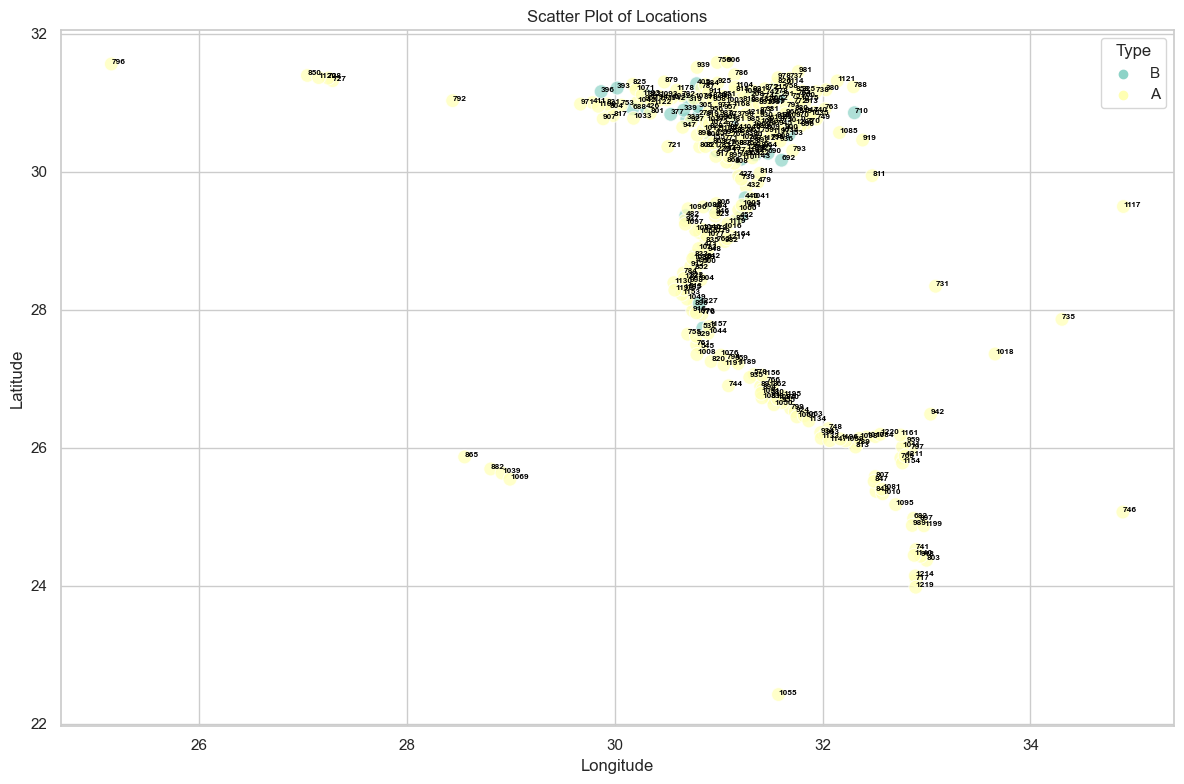

In [275]:
plotDataFrameLongLatWithType(resultDfOPTICSOPT2,showdistance=True,showNumber=True)

In [276]:
outputDF=resultDfOPTICSOPT2[["ID","Type","Latitude","Longitude","updatedEstimastedSales"]]
outputDF.rename(columns={"updatedEstimastedSales":"expectedsales"},inplace=True)

In [277]:
outputDF.to_excel("selectedLocations.xlsx")